## I. CLUSTER DYNAMICS

### Numerical Implementation
The numerical implementation of the TF model follows the approach of Kelton, Greer, and Thompson[^1] as used in previous works. The cluster size changes via single molecule attachment and detachment, as described by the master equations.

### Master Equations
The rate of change of the number density of *i*-mers is given by:

$$
\frac{dN_i}{dt} = D_{i+1}N_{i+1} + A_{i-1}N_{i-1} - (D_i + A_i)N_i
$$

Where:
- $ N_i $ is the number density of *i*-mers,
- $ i \geq u $, and *u* is the minimum cluster size treated numerically,
- $ A_i $ and $ D_i  4are the rates of single molecule attachment and detachment, respectively.

### Steady State Balance
At steady state ($ \theta = 0 $), the balance is given by:

$$
0 = A_{i-1}N_{eq,i-1} - D_iN_{eq,i+1}
$$

### Equilibrium Number Densities
The equilibrium number densities follow the Boltzmann distribution:

$$
N_{eq,i} = N_1 \exp\left(-\frac{W_i}{kT}\right)
$$

Where:
- $ W_i $ is the free energy of formation of the *i*-mer,
- $ k $ is the Boltzmann's constant,
- $ T $ is the temperature.

### Formation Rate of Clusters
The formation rate of clusters is concerned with the net formation rate of clusters of given size and the number density of such clusters. It is expressed as:

$$
J_i = A_iN_i - D_{i+1}N_{i+1}
$$

### Observable Cluster Size
The number of molecules in the cluster of "observable" size is:

$$
N_{>i_o} = \sum_{i=i_o+1}^{\infty} N_i
$$

### Boundary Conditions
The initial and boundary conditions are set as follows:
- At $ t = 0 $, the cluster population is $ N_i = N_{eq,i} $ for $ i < u $,
- $ N_i = 0 $ for $ i \geq u $ if not stated otherwise.

This corresponds to quenching from high temperatures where the molecules are dominantly in the monomer state; i.e., $ N_i = N_1 \exp\left(-\frac{W_i}{kT}\right) $, where $ W_i = 0 $ as monomers of the parent phase are not distinguishable.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import Nucleation_Dynamics as nd
from extensisq import BS5, SSV2stab, Pr9, CK5, CFMR7osc, Pr7
import Nucleation_Dynamics as nd
from diffeqpy import de, ode

import scienceplots
plt.style.use(['science','ieee'])

  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`


For crystal nucleation in melt or glass, the rate of formation, \( A_i \), is expressed as:

$$
A_i = bD\lambda^{-2i/3} \exp\left(-\frac{W_{i+1} - W_i}{2kT}\right)
$$

where:
- $ b = 24 $ is a geometrical factor,
- $D $ is the diffusion coefficient,
- $\lambda $ is the jump distance in the parent phase.

### Initial and Boundary Conditions
The initial and boundary conditions applied are as follows:
- At $ t = 0 $, the cluster population is $ N_i = N_{eq,i} $ for $ i < u $,
- $ N_i = 0 $ for $ i \geq u $.

This corresponds to quenching from high temperatures where the molecules are dominantly in the monomer state; i.e., $ N_1 = N_L \exp\left(-\frac{W_1}{kT}\right) $, where $ W_1 = 0 $ as monomers of the parent and new phases cannot be distinguished.

The number density of monomers is kept constant at $ N_1(t) = N_{eq,1} $. A "no-depletion" boundary condition is applied for the monomers (lower boundary condition); i.e., their number density is constant. The number of molecules in the system depends on the boundary conditions, with a different upper boundary condition applied to enforce the conservation of supercritical clusters by closing the system at $ i_{max} $ and setting the rate coefficients $ A_{i_{max}} $ and $ D_{i_{max} + 1} $ equal to zero. 


For simplicity, spherical clusters with a sharp dividing surface, having the same composition as the parent phase, are assumed. Following Gibbs, the reversible work of formation of a cluster of size \( n \), constructed from \( n \) monomers, or molecules, is:

$$
\Delta G_n = n\Delta G' + (36\pi)^{\frac{1}{3}}v^{\frac{2}{3}}n^{\frac{2}{3}}\sigma ,
$$

where $ \Delta G' $ is the Gibbs free energy per molecule of the new phase less that of the initial phase, $ v $ is the molecular volume and $ \sigma $ is the interfacial energy per unit area. The surface energy penalty is dominant for small clusters, leading to a maximum in $ \Delta G_n $ at the critical size, $ n* $,

$$
n* = \frac{32\pi \sigma^3}{3v|\Delta G_v|^3} ,
$$

where $ \Delta G_v $ is the free energy difference per unit volume, $ \Delta G'/v $. Since clusters smaller than $ n* $ will on average shrink, while those larger than $ n* $ will on average grow, the nucleation rate is in a crude sense the production of postcritical clusters. Clusters are assumed to evolve in size by a series of bimolecular reactions.


In [5]:
# Ejemplo de uso de la clase

path = "data/lithium_disillicate.json"

cluster_physics = nd.ClusterPhysics(path)

print(f"Critical radius: {cluster_physics.critical_radius}")
print(f"Critical Gibbs free energy: {cluster_physics.critical_energy_barrier}")
print(f"Critical number of atoms: {cluster_physics.critical_number_of_molecules}")

Critical radius: 8.184545454545456e-10 meter
Critical Gibbs free energy: 4.2089037887339014e-19 joule
Critical number of atoms: 23.04237422754489 dimensionless


# Comparison free eneregy Gibbs (CNT model)

/home/alexandre_sureda/miniconda3/envs/neutronics/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


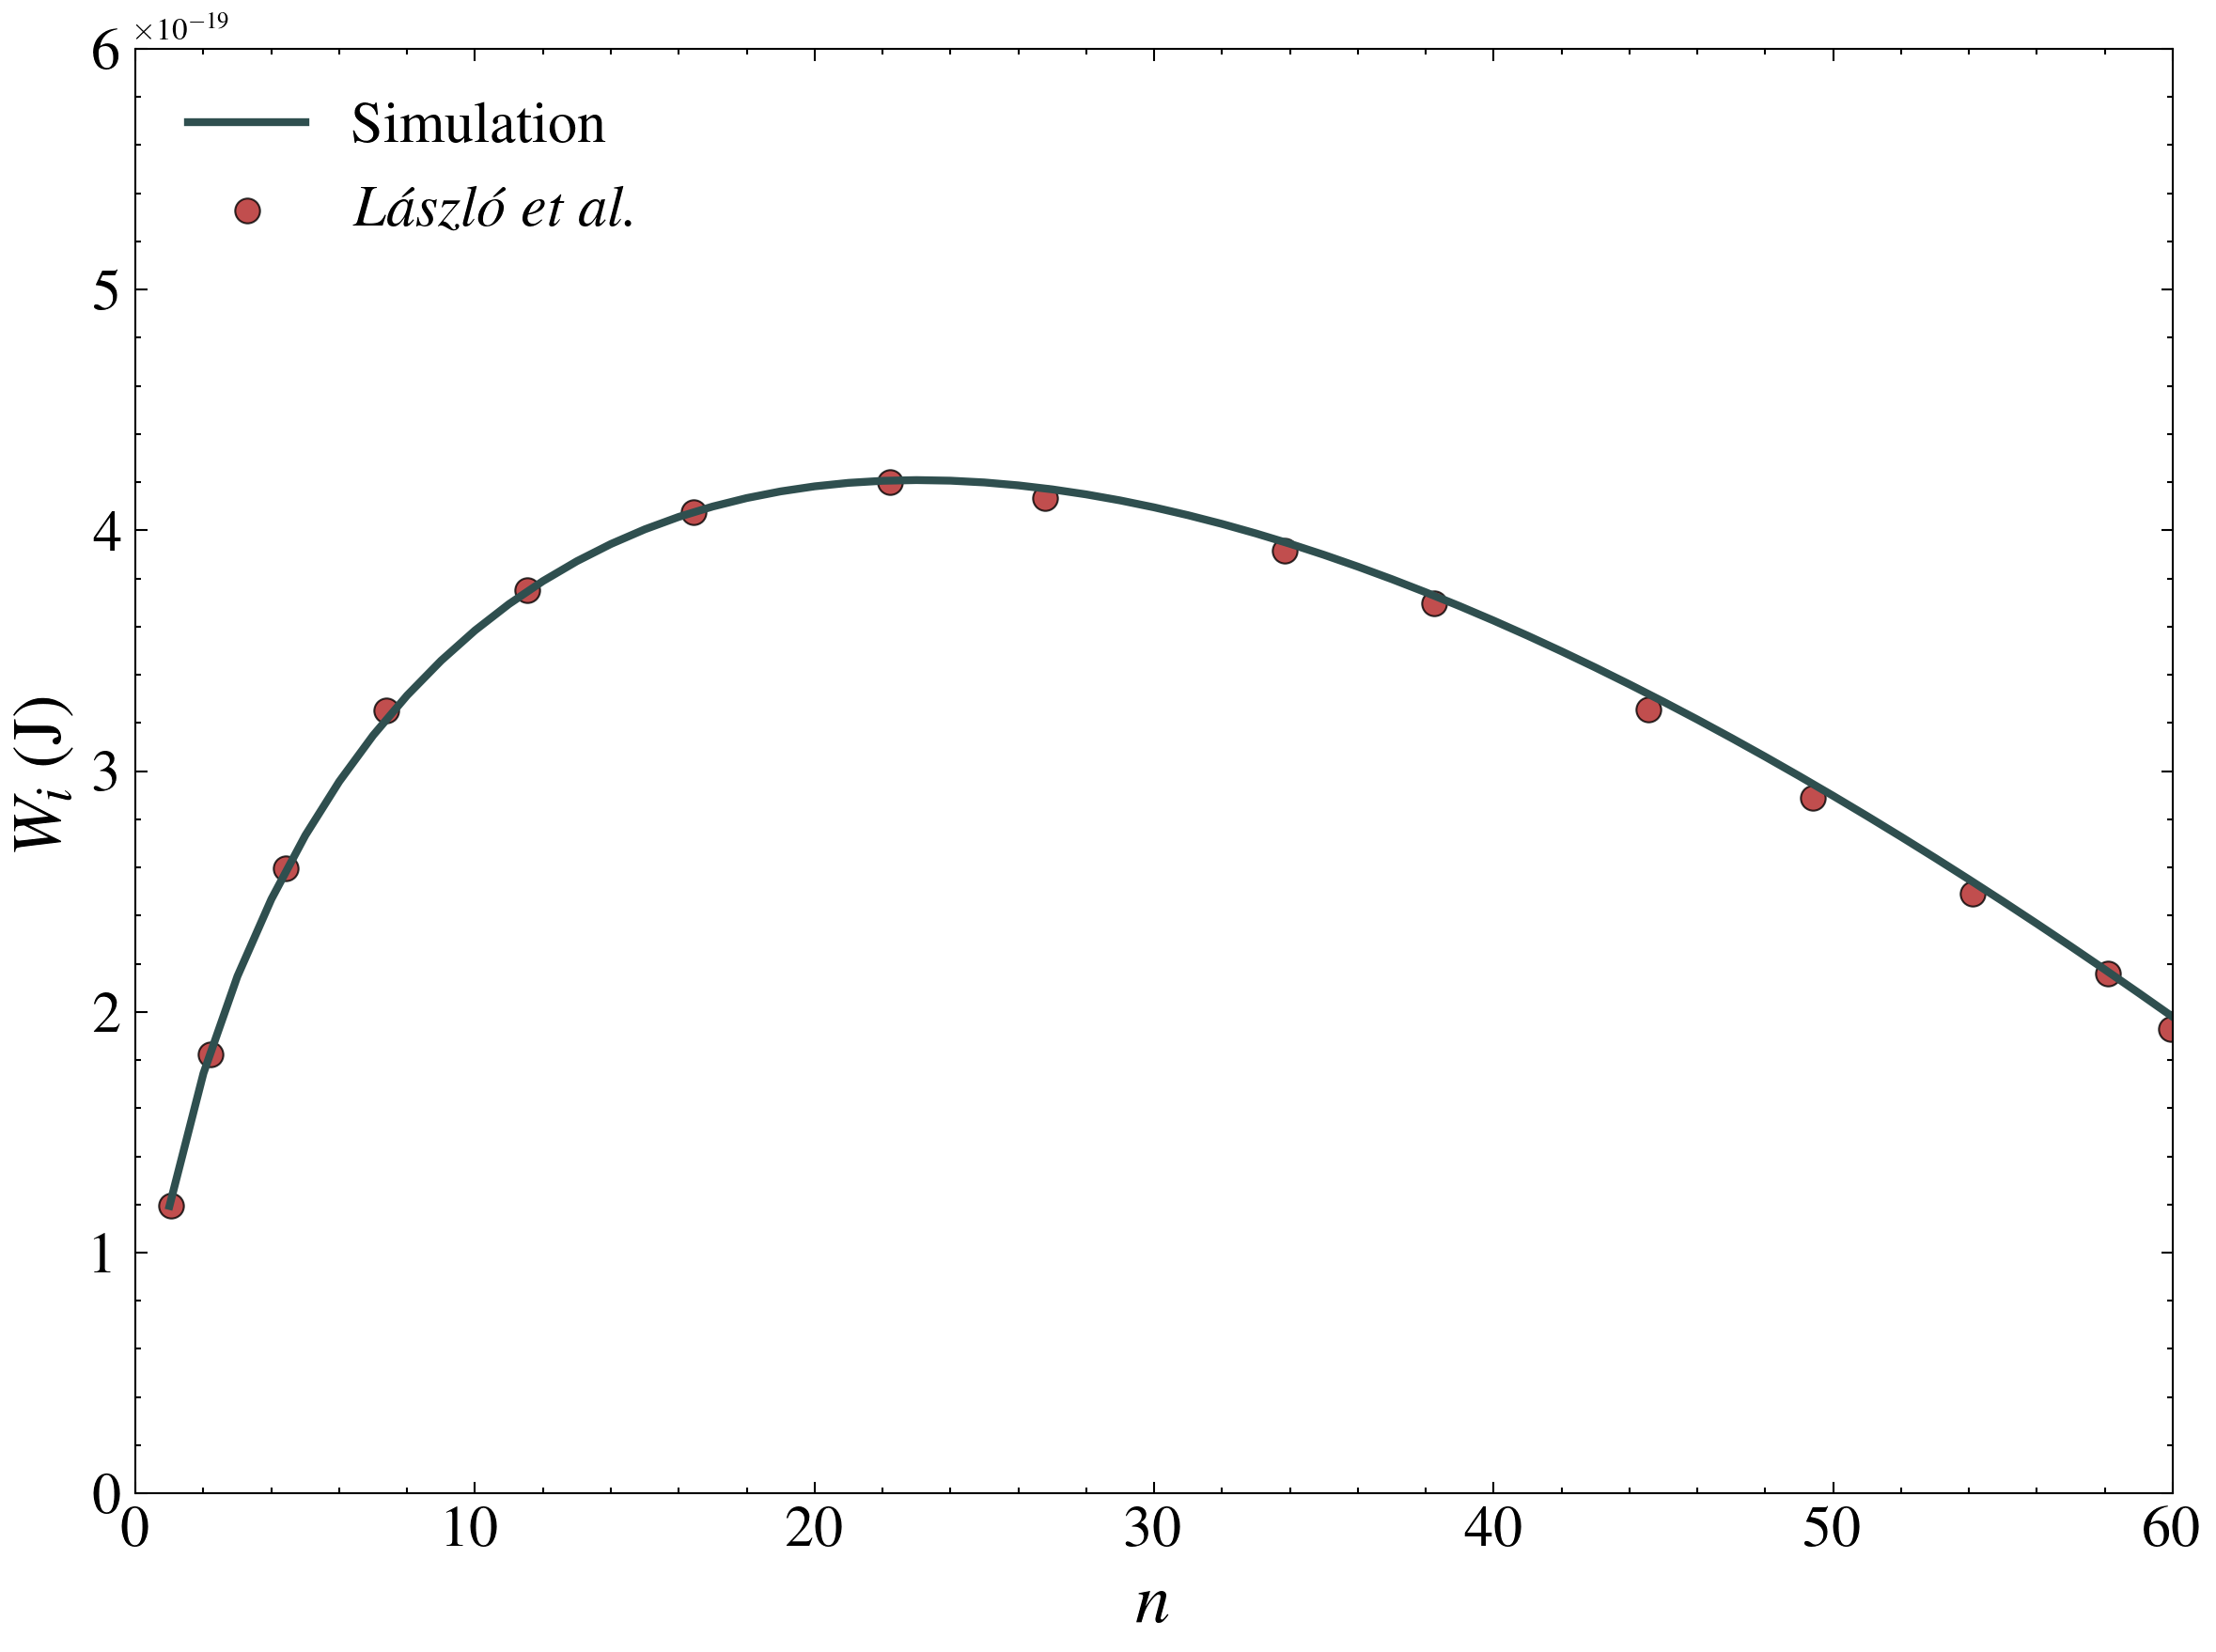

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Mejoras en la tipografía para revistas de física
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

# Carga de datos
df = pd.read_csv('data/lithium_disillicate_free_energy_40n_laszlo.csv')

# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Preparación de datos
n = np.linspace(1, 60, 60)
# Asumiendo que 'cluster_physics.total_free_energy(n)' es una función definida previamente
ax.plot(n, cluster_physics.total_free_energy(n), label='Simulation', color='darkslategray', linewidth=2, linestyle='-')

# Dibujo de puntos con mejor color y mayor grosor de línea
ax.scatter(df["X"], df["Y"]*1e-19, label=r'\textit{László et al.}', s=40, color='firebrick', edgecolor='black', linewidth=0.5, alpha=0.8)

# Etiquetas y título con LaTeX para un aspecto profesional
ax.set_xlabel(r'$n$', fontsize=18)
ax.set_ylabel(r'$W_i$ (J)', fontsize=18)

# Ticks mejorados
ax.tick_params(axis='both', which='major', labelsize=15)

# Leyenda con tamaño de fuente aumentado y sin marco para un look limpio
ax.legend(loc='upper left', fontsize=15, frameon=False)

# Límites ajustados para enfocar en los datos relevantes
ax.set_xlim(0, 60)
ax.set_ylim(0, 6*1e-19)

# Ajuste de los márgenes y guardado con alta resolución
plt.tight_layout()

# Mostrar gráfico
plt.show()


In [72]:
MAX_NUMBER_MOLECULES = int(40)
number_clusters_start = 20
steps = int(1e6)
dt = 1e-8/cluster_physics.unbiased_jump_rate.magnitude
dt = dt*1e6
t_span = (0.0, dt*int(steps))

t_eval = np.linspace(*t_span, int(1e5))
sim = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method='Radau', t_eval=t_eval, rtol=1e-8, atol=1e-8, max_step=dt*1e2)

sim2 = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, MAX_NUMBER_MOLECULES, boundary_type="open")
sim2.simulate(method='Radau', t_eval=t_eval, rtol=1e-8, atol=1e-8, max_step=dt*1e2)


{'execution_time': 5.095827579498291, 'success': True, 'nfev': 75384}
{'execution_time': 4.929887056350708, 'success': True, 'nfev': 75419}


## Comparison cluster disitribution 

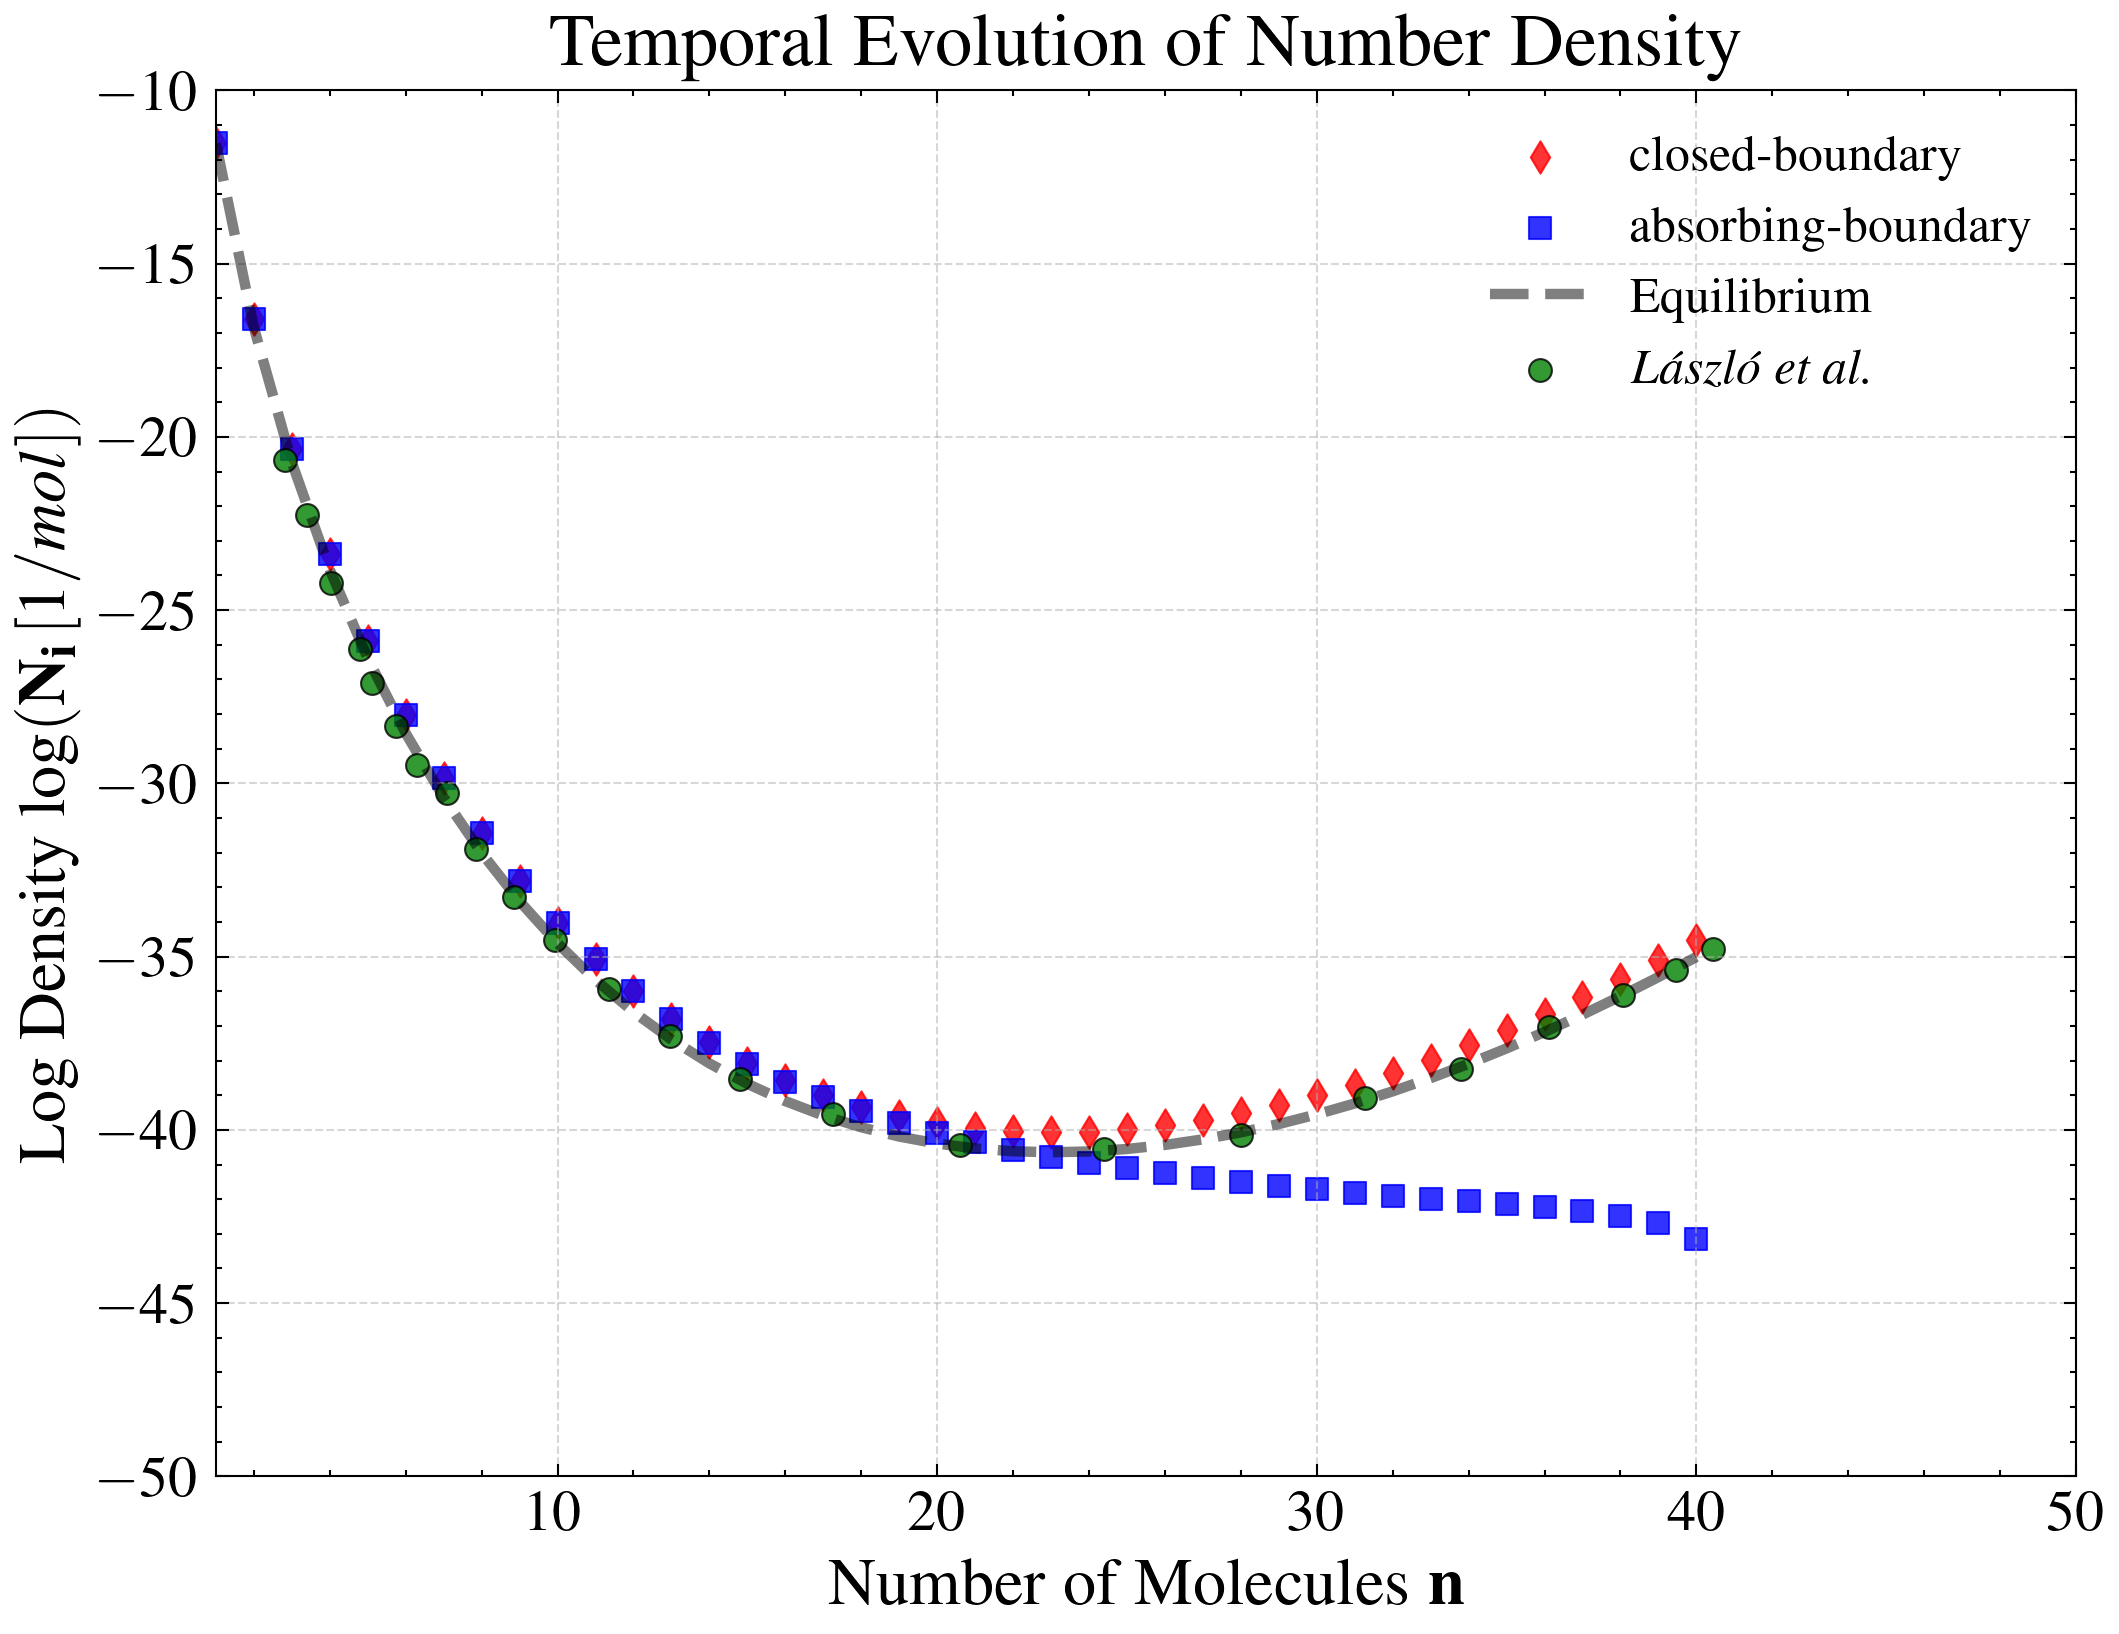

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Definiciones previas omitidas para brevedad

# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Carga de datos
df = pd.read_csv('data/lithium_disillicate_40n_laszlo.csv')

# Definir el rango de números de moléculas
number_molecules_array = np.arange(1, MAX_NUMBER_MOLECULES + 1)
        
plt.scatter(number_molecules_array, np.log(sim.cluster_array[:, -1] / cluster_physics.AVOGADRO.magnitude),
            label="closed-boundary", s=30, marker='d', color='red', edgecolor='red', linewidth=0.5, alpha=0.8)

plt.scatter(number_molecules_array, np.log(sim2.cluster_array[:, -1] / cluster_physics.AVOGADRO.magnitude),
            label="absorbing-boundary", marker='s', s=30, color = 'blue', edgecolor='blue', linewidth=0.5, alpha=0.8)

# Añadir la línea de equilibrio con estilo mejorado
plt.plot(number_molecules_array, np.log(cluster_physics.number_density_equilibrium(number_molecules_array).magnitude / cluster_physics.AVOGADRO.magnitude),
         label="Equilibrium", color='black',alpha=0.5, linestyle='--', linewidth=2.5)

# Añadir la línea de equilibrio con estilo mejorado
plt.scatter(df['X'], df['Y'],
         label=r'\textit{László et al.}', color='green', s=30, edgecolor='black', linewidth=0.5, alpha=0.8)


# Ajustes finales de etiquetas y títulos con calidad de publicación
plt.xlabel(r"Number of Molecules $\mathbf{n}$", fontsize=16)
plt.ylabel(r"Log Density $\log(\mathbf{N_i} \, [1/mol])$", fontsize=16)
plt.title("Temporal Evolution of Number Density", fontsize=18)
plt.legend(fontsize=12, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1, MAX_NUMBER_MOLECULES+10)
plt.ylim(-50, -10)
plt.yticks(np.arange(-50, -9, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Ligera cuadrícula para mejorar la lectura

plt.show()


/tmp/ipykernel_8111/3335044436.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores_sim1 = cm.get_cmap('Blues', 12)  # Más suave y profesional para el primer conjunto
/tmp/ipykernel_8111/3335044436.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores_sim2 = cm.get_cmap('winter', 12)  # Más suave y profesional para el primer conjunto


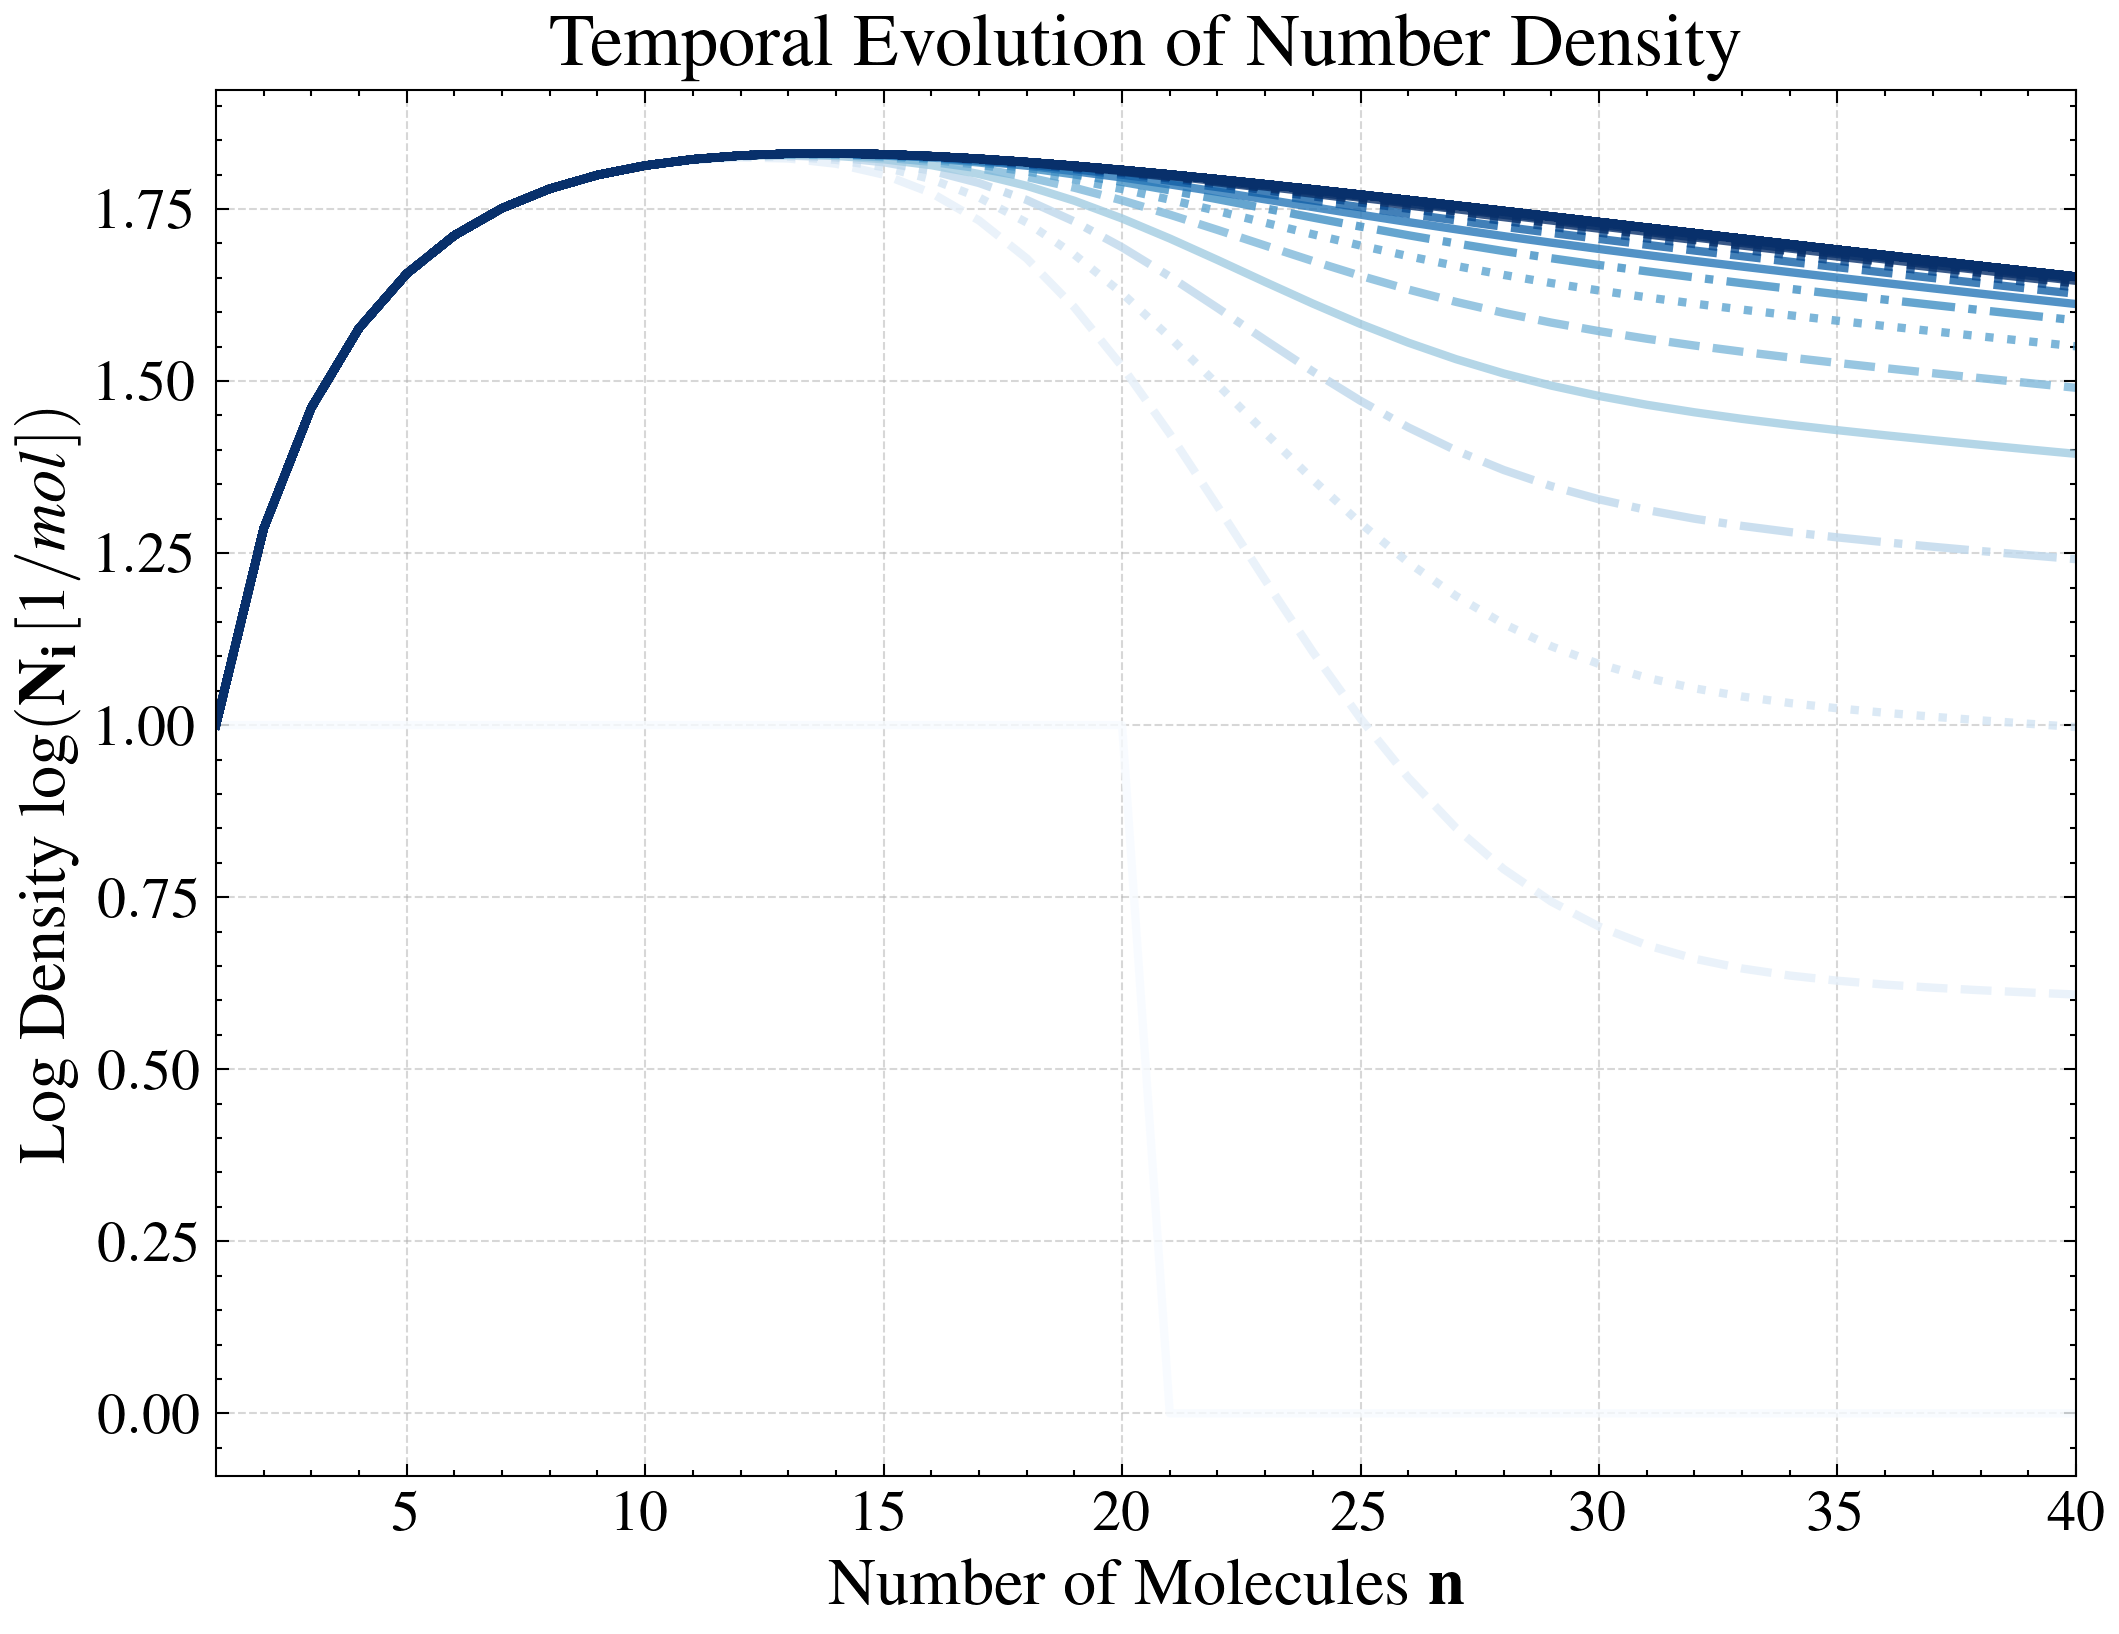

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Definiciones previas omitidas para brevedad

# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Carga de datos
df = pd.read_csv('data/lithium_disillicate_40n_laszlo.csv')

# Definir el rango de números de moléculas
number_molecules_array = np.arange(1, MAX_NUMBER_MOLECULES + 1)
color = cm.viridis(np.linspace(0, 1, 200)) 
colores_sim1 = cm.get_cmap('Blues', 12)  # Más suave y profesional para el primer conjunto
colores_sim2 = cm.get_cmap('winter', 12)  # Más suave y profesional para el primer conjunto

num_points = 100
indices = np.linspace(0, len(sim.time) - 1, num_points, dtype=int)

for i, index in enumerate(indices):
    plt.plot(number_molecules_array, (sim.cluster_array[:, index] / cluster_physics.AVOGADRO.magnitude)/(cluster_physics.number_density_equilibrium(number_molecules_array).magnitude / cluster_physics.AVOGADRO.magnitude),
        color = colores_sim1(i) , linewidth=2, alpha=0.8)

# i = 0       
# for index, time in enumerate(sim.time):
#     if index % 1000 == 0:
#         plt.plot(number_molecules_array, (sim.cluster_array[:, index] / cluster_physics.AVOGADRO.magnitude)/(cluster_physics.number_density_equilibrium(number_molecules_array).magnitude / cluster_physics.AVOGADRO.magnitude),
#             color = colores_sim1(i) , label="closed-boundary",  marker='o', markersize=5, alpha=0.8)
#         i += 1

indices2 = np.linspace(0, len(sim2.time) - 1, num_points, dtype=int)
      
# for i, index in enumerate(indices2):
#     plt.plot(number_molecules_array, (sim2.cluster_array[:, index] / cluster_physics.AVOGADRO.magnitude)/(cluster_physics.number_density_equilibrium(number_molecules_array).magnitude / cluster_physics.AVOGADRO.magnitude),
#         color = colores_sim2(i) ,  marker='o', markersize=5, alpha=0.8)
    


# Ajustes finales de etiquetas y títulos con calidad de publicación
plt.xlabel(r"Number of Molecules $\mathbf{n}$", fontsize=16)
plt.ylabel(r"Log Density $\log(\mathbf{N_i} \, [1/mol])$", fontsize=16)
plt.title("Temporal Evolution of Number Density", fontsize=18)
#plt.legend(fontsize=12, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1, MAX_NUMBER_MOLECULES)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Ligera cuadrícula para mejorar la lectura

plt.show()


/tmp/ipykernel_8111/684574553.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


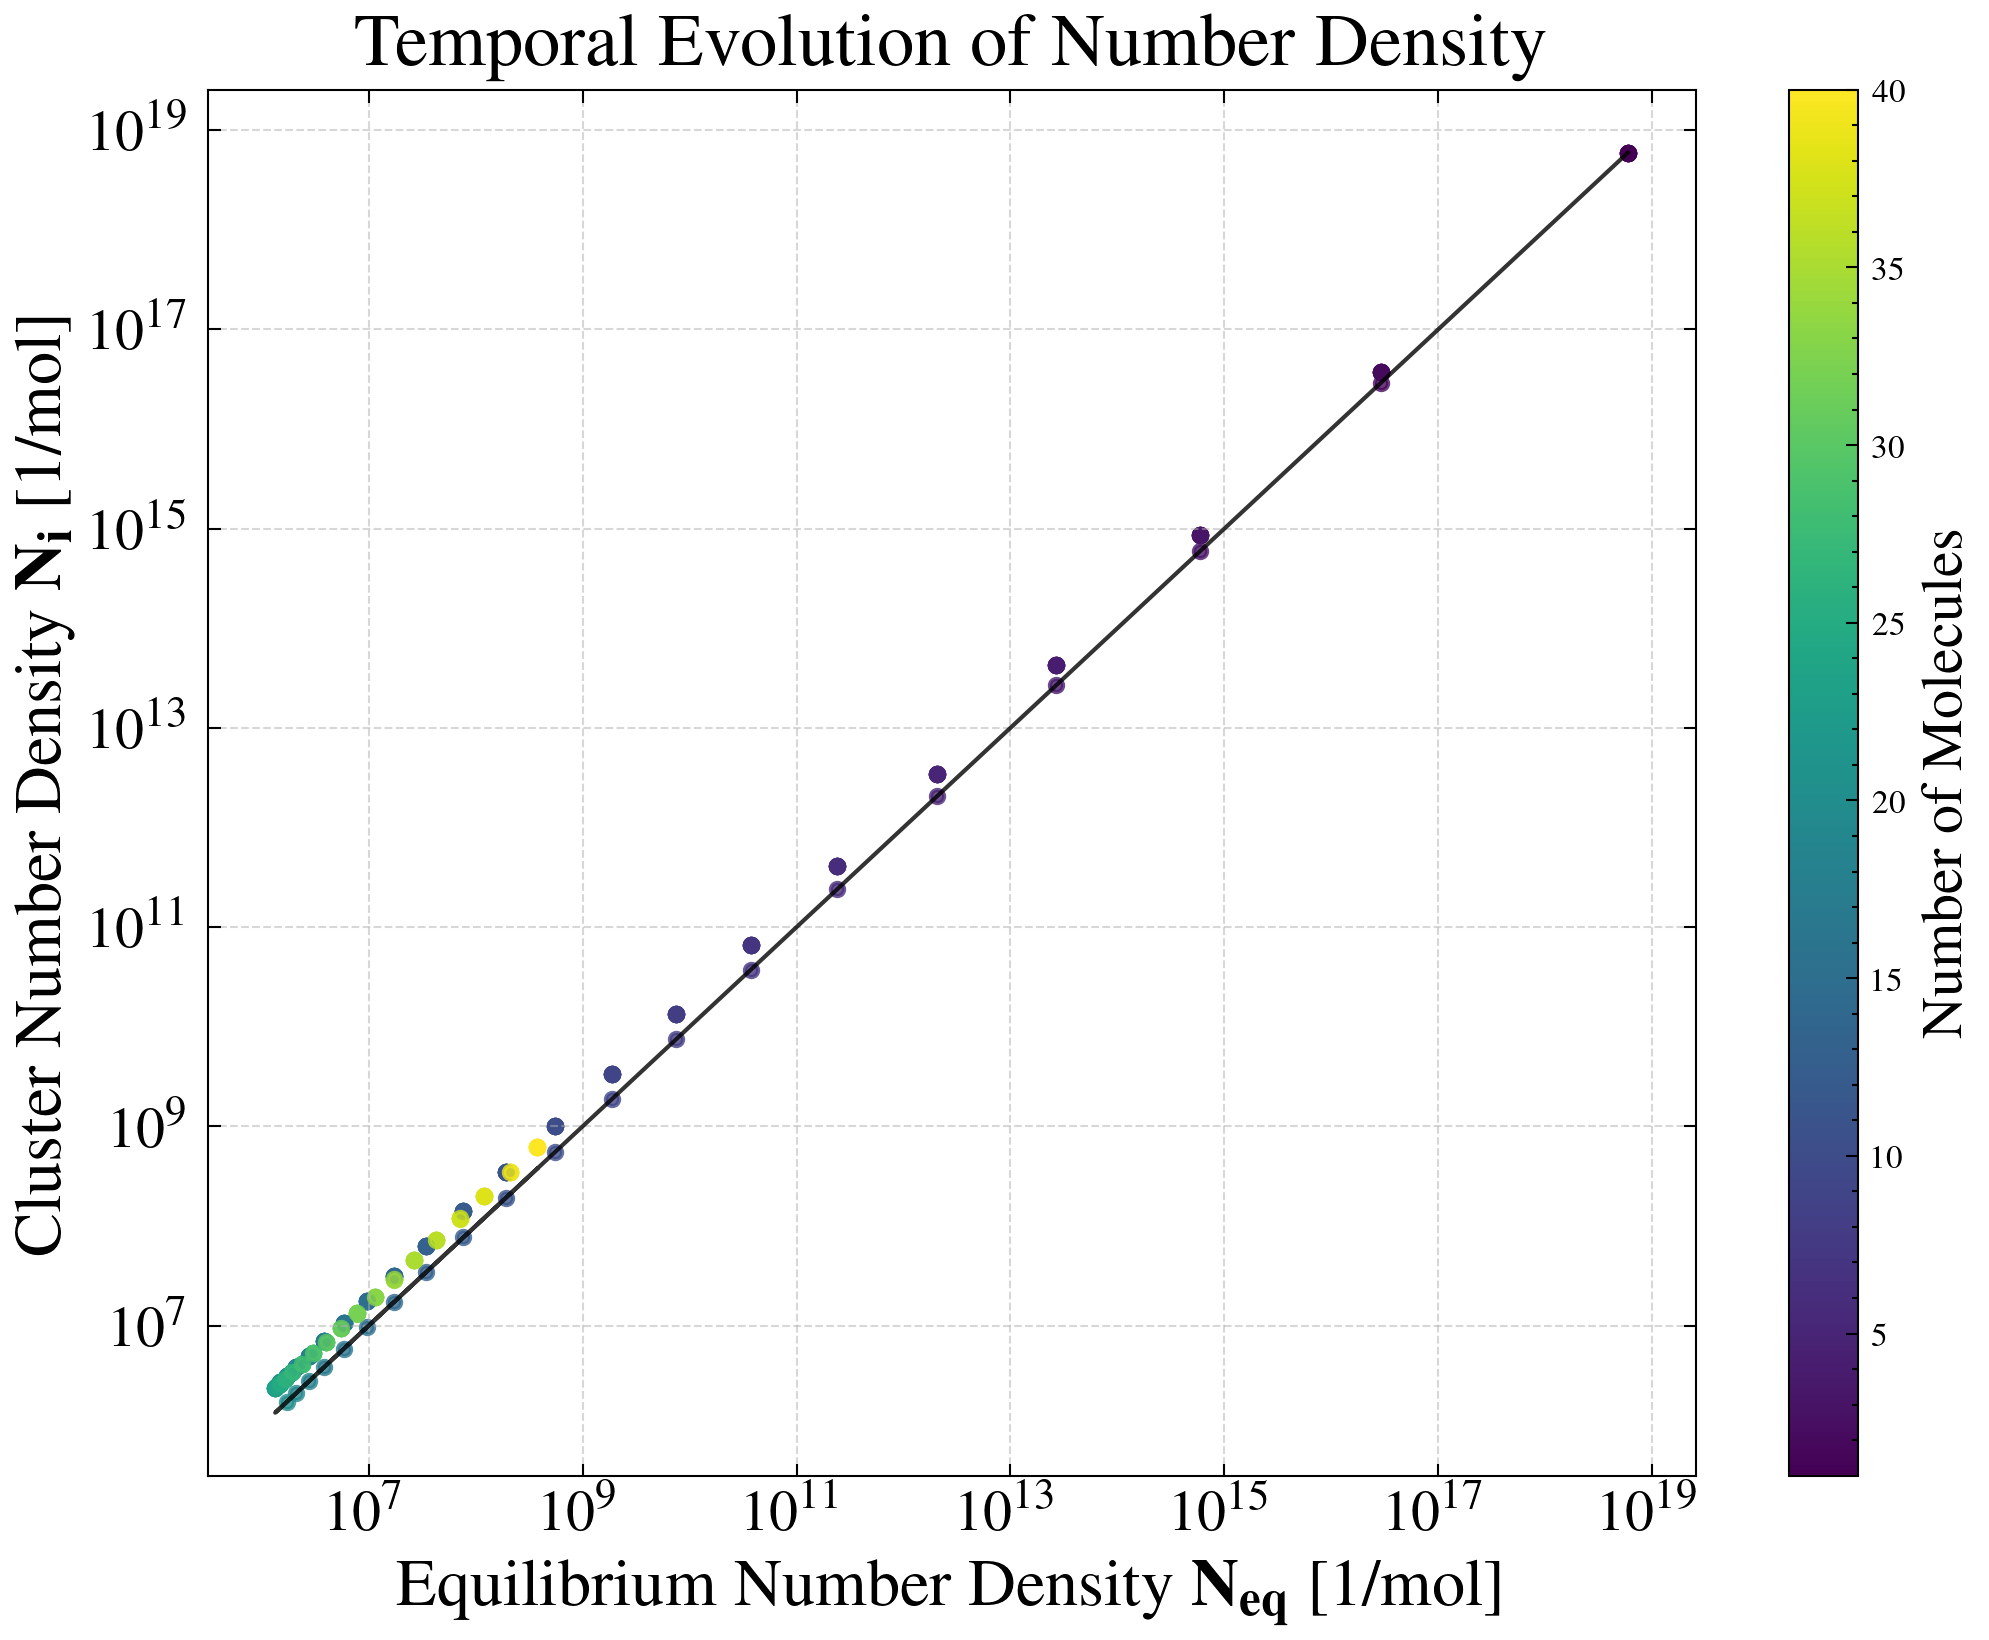

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Definir el rango de números de moléculas
number_molecules_array = np.arange(1, MAX_NUMBER_MOLECULES + 1)
# Genera el colormap basado en el número total de moléculas
colormap = cm.viridis(np.linspace(0, 1, MAX_NUMBER_MOLECULES))

# Define el número de puntos (tiempos) a graficar
num_points = 10
indices = np.linspace(0, len(sim.time) - 1, num_points, dtype=int)

# Itera a través de cada tiempo
for i, index in enumerate(indices):
    # Para cada tiempo, itera sobre cada número de moléculas
    for j, num_mol in enumerate(number_molecules_array):
        # Escoge el color basado en el número de moléculas
        color = colormap[j]
        # Grafica cada punto con su color correspondiente al número de moléculas
        plt.scatter(cluster_physics.number_density_equilibrium(num_mol).magnitude, 
                    sim.cluster_array[j, index], 
                    color=color, s=10, alpha=0.8)
plt.plot(cluster_physics.number_density_equilibrium(number_molecules_array).magnitude, cluster_physics.number_density_equilibrium(number_molecules_array).magnitude ,alpha=0.8)

# Ajustes finales de etiquetas y títulos con calidad de publicación
plt.xlabel(r"Equilibrium Number Density $\mathbf{N_{eq}}$ [1/mol]", fontsize=16)
plt.ylabel(r"Cluster Number Density $\mathbf{N_{i}}$ [1/mol]", fontsize=16)
plt.title("Temporal Evolution of Number Density", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Crear y añadir colorbar que corresponde al número de moléculas
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=1, vmax=MAX_NUMBER_MOLECULES))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Number of Molecules', fontsize=14)

plt.show()


/tmp/ipykernel_8111/768942961.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Spectral")
/tmp/ipykernel_8111/768942961.py:43: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_verticalalignment("bottom")


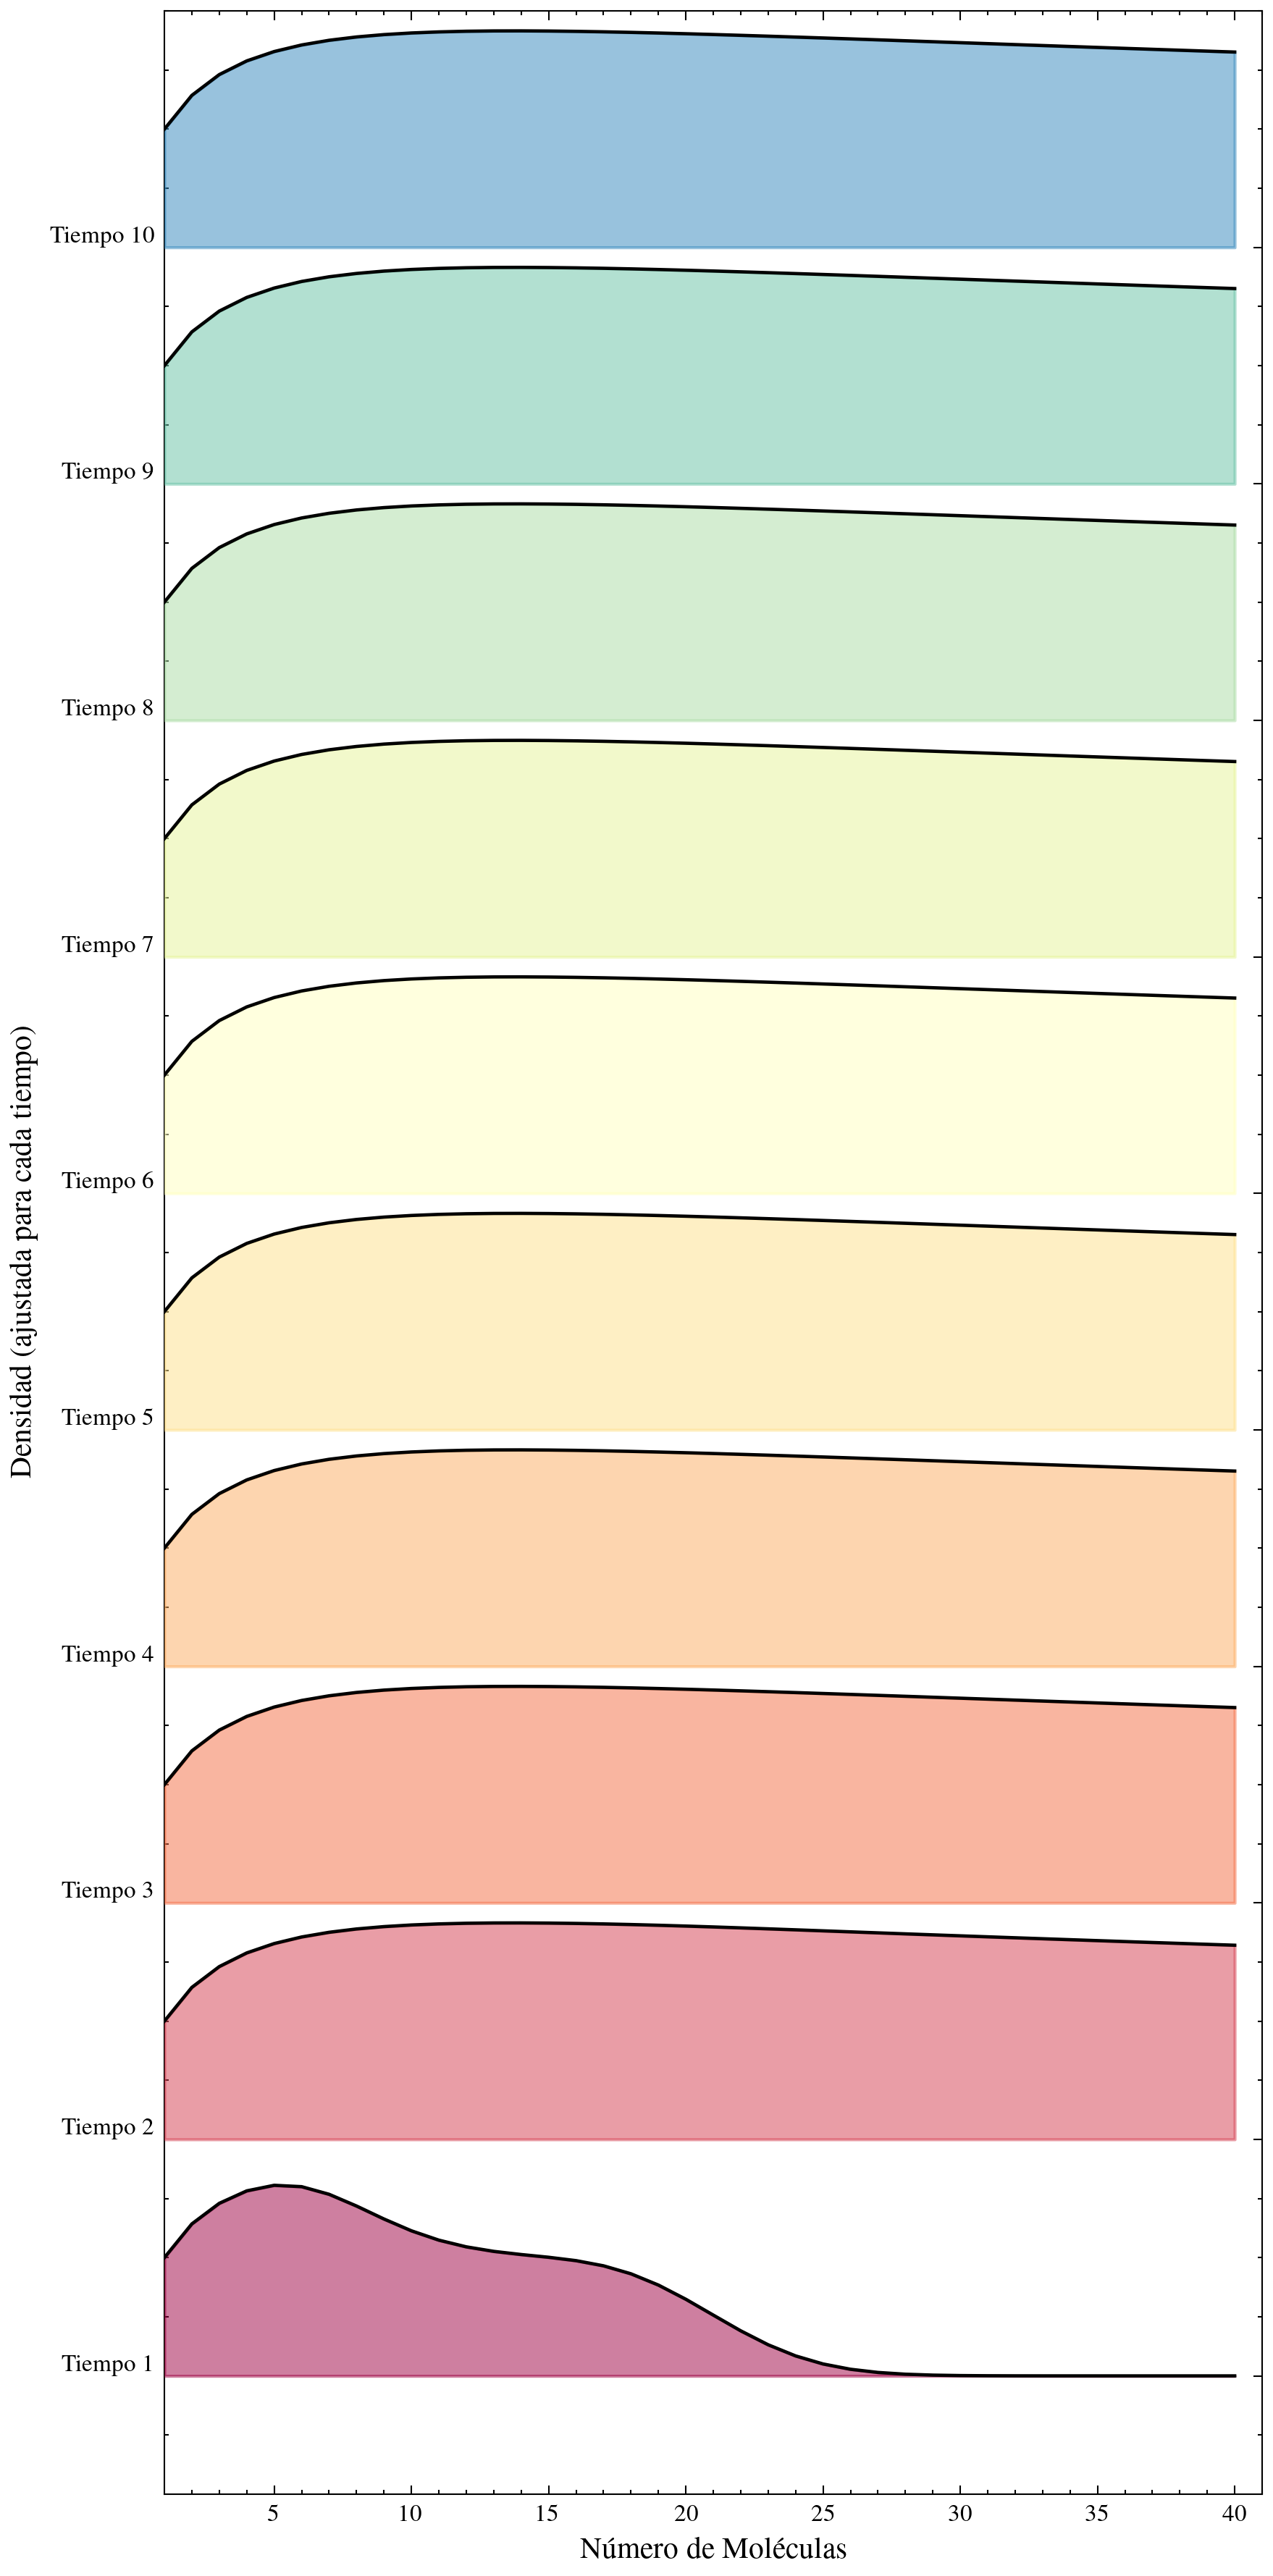

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configuraciones de la paleta de colores y la estética de la gráfica
cmap = cm.get_cmap("Spectral")

# Supongamos que 'num_points' es el número de diferentes tiempos que quieres mostrar
num_points = 10
# Supongamos que 'indices' selecciona momentos específicos en 'sim.time'
indices = np.linspace(2, len(sim.time) - 1, num_points, dtype=int)

# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, ax = plt.subplots(figsize=(6, 12), dpi=300)
vertical_spacing = 2  # Espaciado vertical entre cada gráfica

for i, index in enumerate(indices):
    # Simula obtener datos de densidad (reemplaza con tus propios datos)
    Y = sim.cluster_array[:, index] / cluster_physics.number_density_equilibrium(number_molecules_array).magnitude
    X = number_molecules_array

    # Aumenta el desplazamiento para cada serie de tiempo
    offset = i * vertical_spacing
    ax.plot(X, Y + offset, color="black", linestyle='-', linewidth=1.1, zorder=100 - i)
    color = cmap(float(i) / len(indices))  # Usa el índice para variar el color

    # Rellenar bajo la curva con transparencia (alpha)
    ax.fill_between(X, Y + offset, offset, color=color, alpha=0.5, zorder=50 - i)

# Configuraciones de los ejes y la estética
ax.yaxis.set_tick_params(tick1On=False)  # Desactiva ticks del eje y
ax.set_xlim(1, 41)  # Ajusta según tu rango de número de moléculas
ax.set_ylim(-1, num_points * vertical_spacing)  # Ajusta según la cantidad de series y el espaciado

# Línea vertical de referencia
ax.axvline(0.0, ls="--", lw=0.75, color="black", zorder=50)

# Configuración de las etiquetas del eje y
ax.yaxis.set_tick_params(labelleft=True)
ax.set_yticks([i * vertical_spacing for i in range(num_points)])
ax.set_yticklabels(["Tiempo %d" % (i + 1) for i in range(num_points)], fontsize=8)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_verticalalignment("bottom")

# Etiquetas de los ejes
ax.set_xlabel('Número de Moléculas', fontsize=10)
ax.set_ylabel('Densidad (ajustada para cada tiempo)', fontsize=10)

plt.tight_layout()
plt.show()


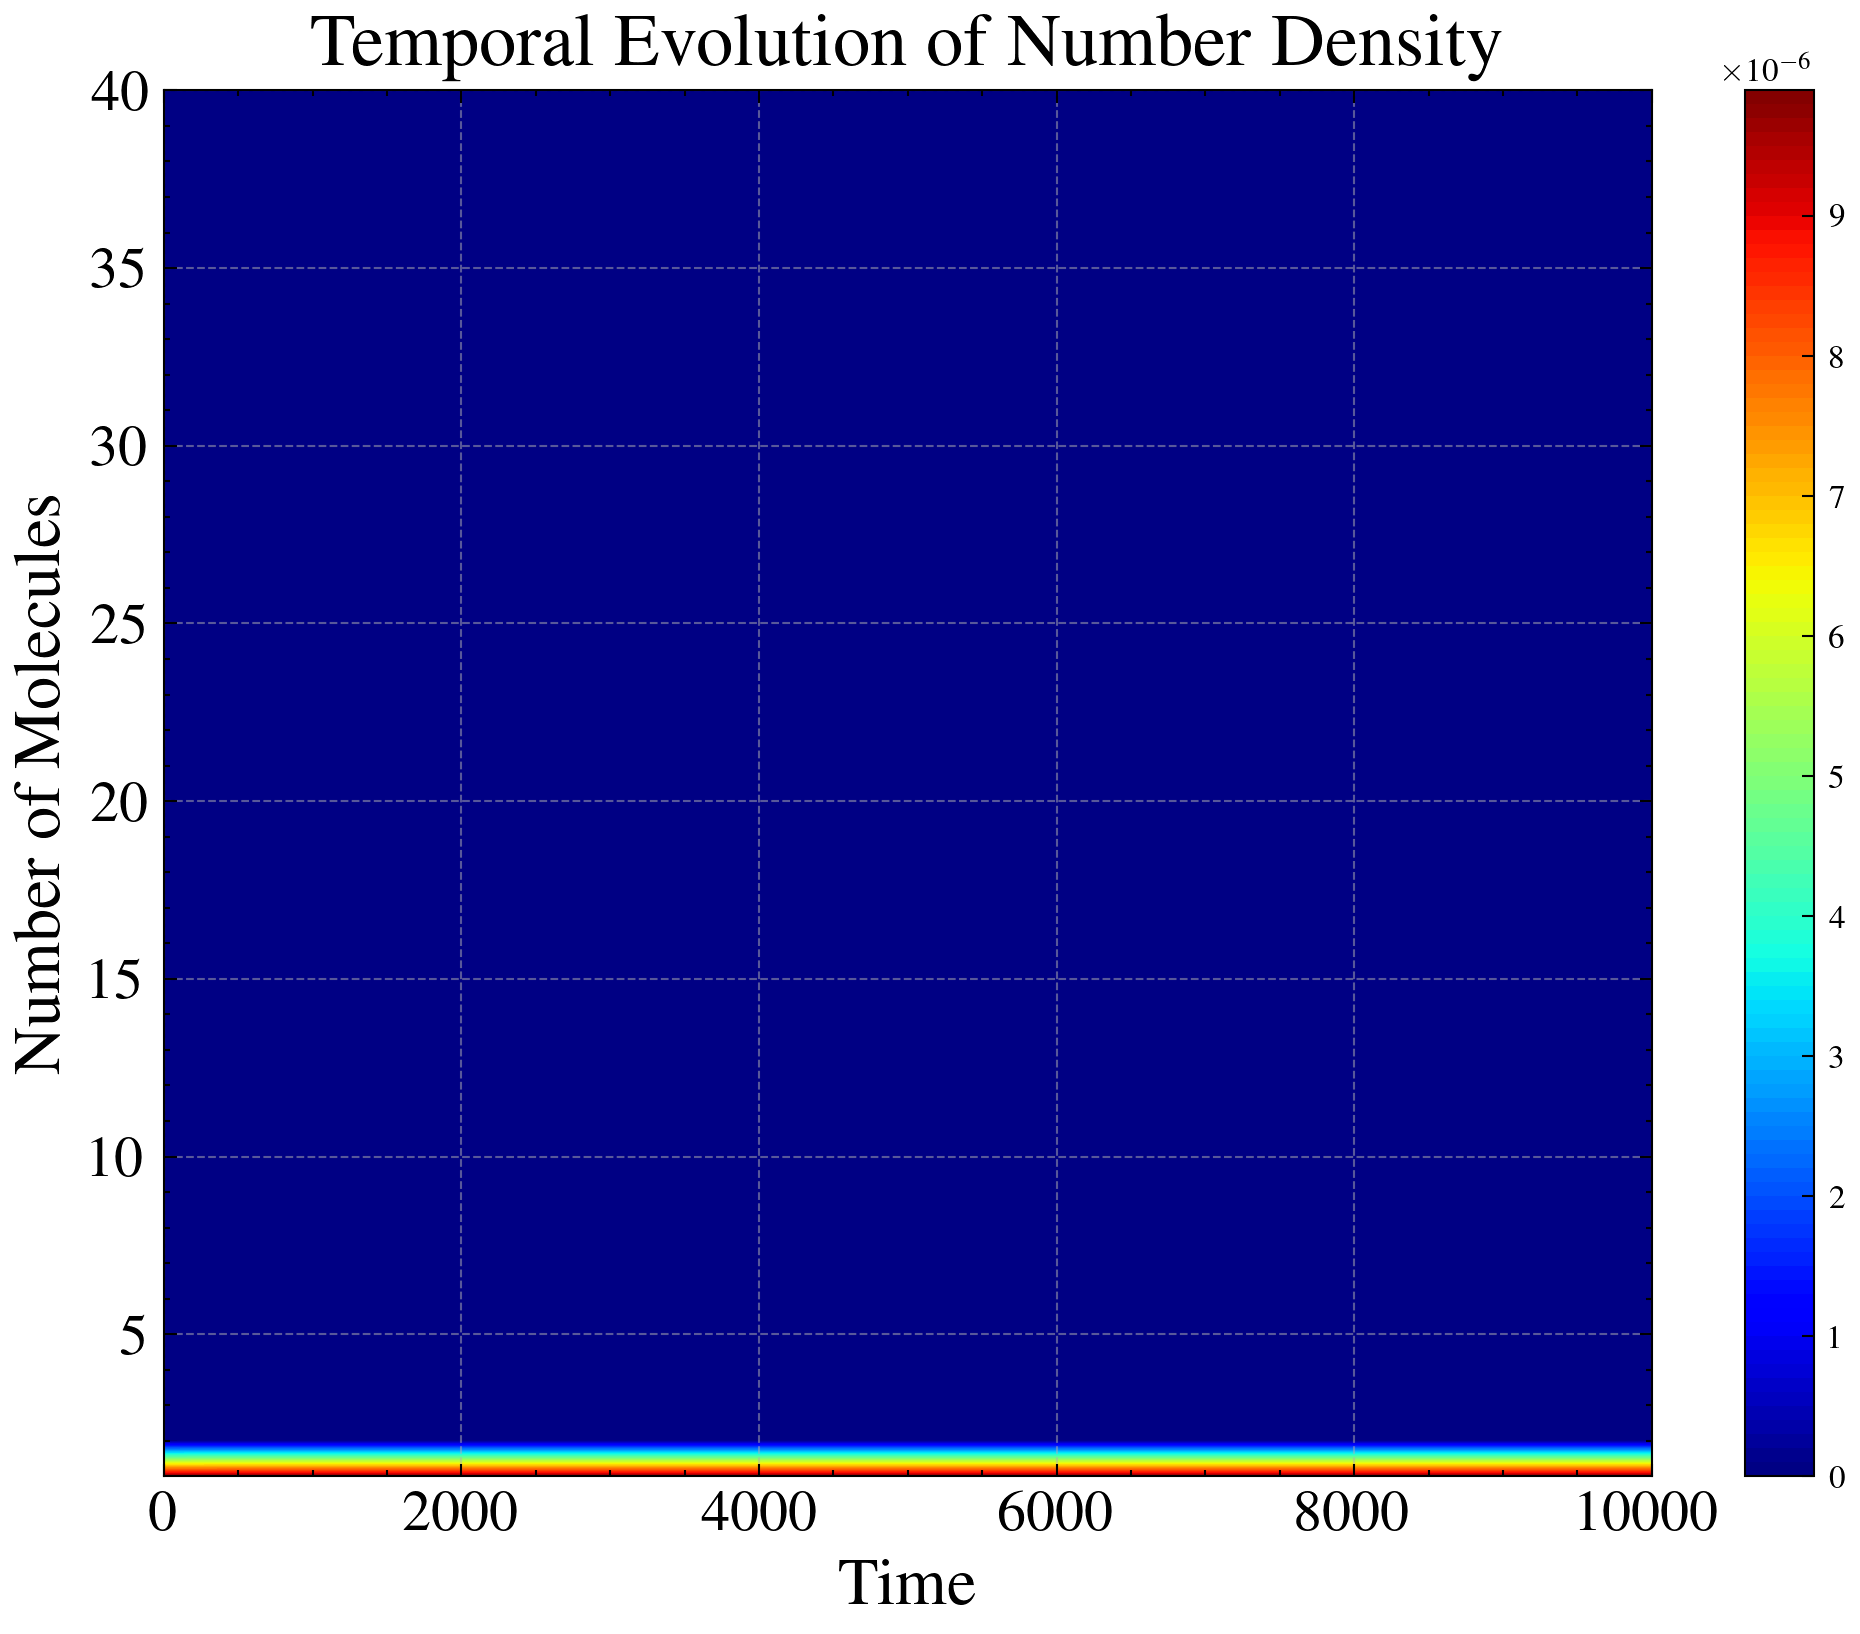

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Asegúrate de tener esta importación si vas a usar pd.read_csv
from matplotlib import cm

# Carga de datos y definiciones previas
df = pd.read_csv('data/lithium_disillicate_40n_laszlo.csv')
MAX_NUMBER_MOLECULES = 40  # Asume que tienes esta columna o ajusta según tus datos

# Definir el rango de tiempos y números de moléculas para el gráfico de contorno
number_molecules_array = np.arange(1, MAX_NUMBER_MOLECULES + 1)
time_array = np.linspace(sim2.time.min(), sim2.time.max(), num_points)  # Asume que sim.time contiene los tiempos
density_matrix = np.zeros((len(number_molecules_array), num_points))  # Matriz para almacenar los datos

# Calcular los datos de densidad para cada combinación de tiempo y número de moléculas
for t_index, time in enumerate(time_array):
    for n_index, num_mol in enumerate(number_molecules_array):
        # Calcula la densidad para este tiempo y número de moléculas y guárdala en la matriz
        # Nota: Ajusta la siguiente línea según tus cálculos específicos y nombres de variables
        density_matrix[n_index, t_index] = (sim2.cluster_array[num_mol-1, t_index] / cluster_physics.AVOGADRO.magnitude)

# Crear el gráfico de contorno
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
X, Y = np.meshgrid(time_array*cluster_physics.unbiased_jump_rate.magnitude, number_molecules_array)  # Mallas para el gráfico de contorno
contour = ax.contourf(X, Y, np.log10(density_matrix), 100, cmap='jet')  # 20 niveles de contorno y mapa de colores 'viridis'
plt.colorbar(contour)  # Agrega una barra de color para interpretar los niveles

# Ajustes finales de etiquetas, títulos y otros elementos gráficos
plt.xlabel('Time', fontsize=16)
plt.ylabel('Number of Molecules', fontsize=16)
plt.title('Temporal Evolution of Number Density', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm

# Configuraciones iniciales: Reemplaza esto con tus propias configuraciones y datos.
num_molecules = 40  # Número máximo de moléculas, ajusta a tu caso
num_times = len(sim.time)  # Número de puntos de tiempo, ajusta según tus datos
number_molecules_array = np.arange(1, num_molecules + 1)
time_array = np.array(sim.time)  # Asume que tienes un arreglo de tiempos en sim.time

# Matriz para almacenar los datos de densidad
density_data = np.zeros((num_molecules, num_times))

# Llenar la matriz con los datos
for t_index, time in enumerate(time_array):
    for n_index, n_molecules in enumerate(number_molecules_array):
        # Calcula la densidad para este tiempo y número de moléculas
        # Ajusta esta línea para que coincida con cómo calculas tu densidad
        density = (sim.cluster_array[n_molecules - 1, t_index] / cluster_physics.AVOGADRO.magnitude) / \
                  (cluster_physics.number_density_equilibrium(n_molecules).magnitude / cluster_physics.AVOGADRO.magnitude)
        density_data[n_index, t_index] = density

# Crear el gráfico de contorno
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
X, Y = np.meshgrid(time_array, number_molecules_array)  # Tiempos en X, número de moléculas en Y
contour_levels = 20  # Ajusta a tu preferencia para los niveles de contorno
cp = ax.contourf(X, Y, np.log10(density_data + 1), contour_levels, cmap=cm.jet)  # Log para mejorar la visualización
cbar = plt.colorbar(cp)  # Añadir barra de color
cbar.ax.set_ylabel('Log Density')  # Etiqueta de la barra de color

# Ajustes finales del gráfico
ax.set_title('Distribution of Number Density over Time', fontsize=18)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Number of Molecules', fontsize=16)
ax.tick_params(labelsize=14)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Asegura que los ticks del eje X sean enteros
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()


In [48]:
MAX_NUMBER_MOLECULES = int(100)
number_clusters_start = 2
steps = int(1e5)
dt = 1e-8/cluster_physics.unbiased_jump_rate.magnitude
dt = dt*1e6
t_span = (0.0, dt*int(steps))

t_eval = np.linspace(*t_span, int(1e5))
sim = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method='Radau', t_eval=t_eval, rtol=1e-8, atol=1e-8)


{'execution_time': 1.7810206413269043, 'success': True, 'nfev': 12107}


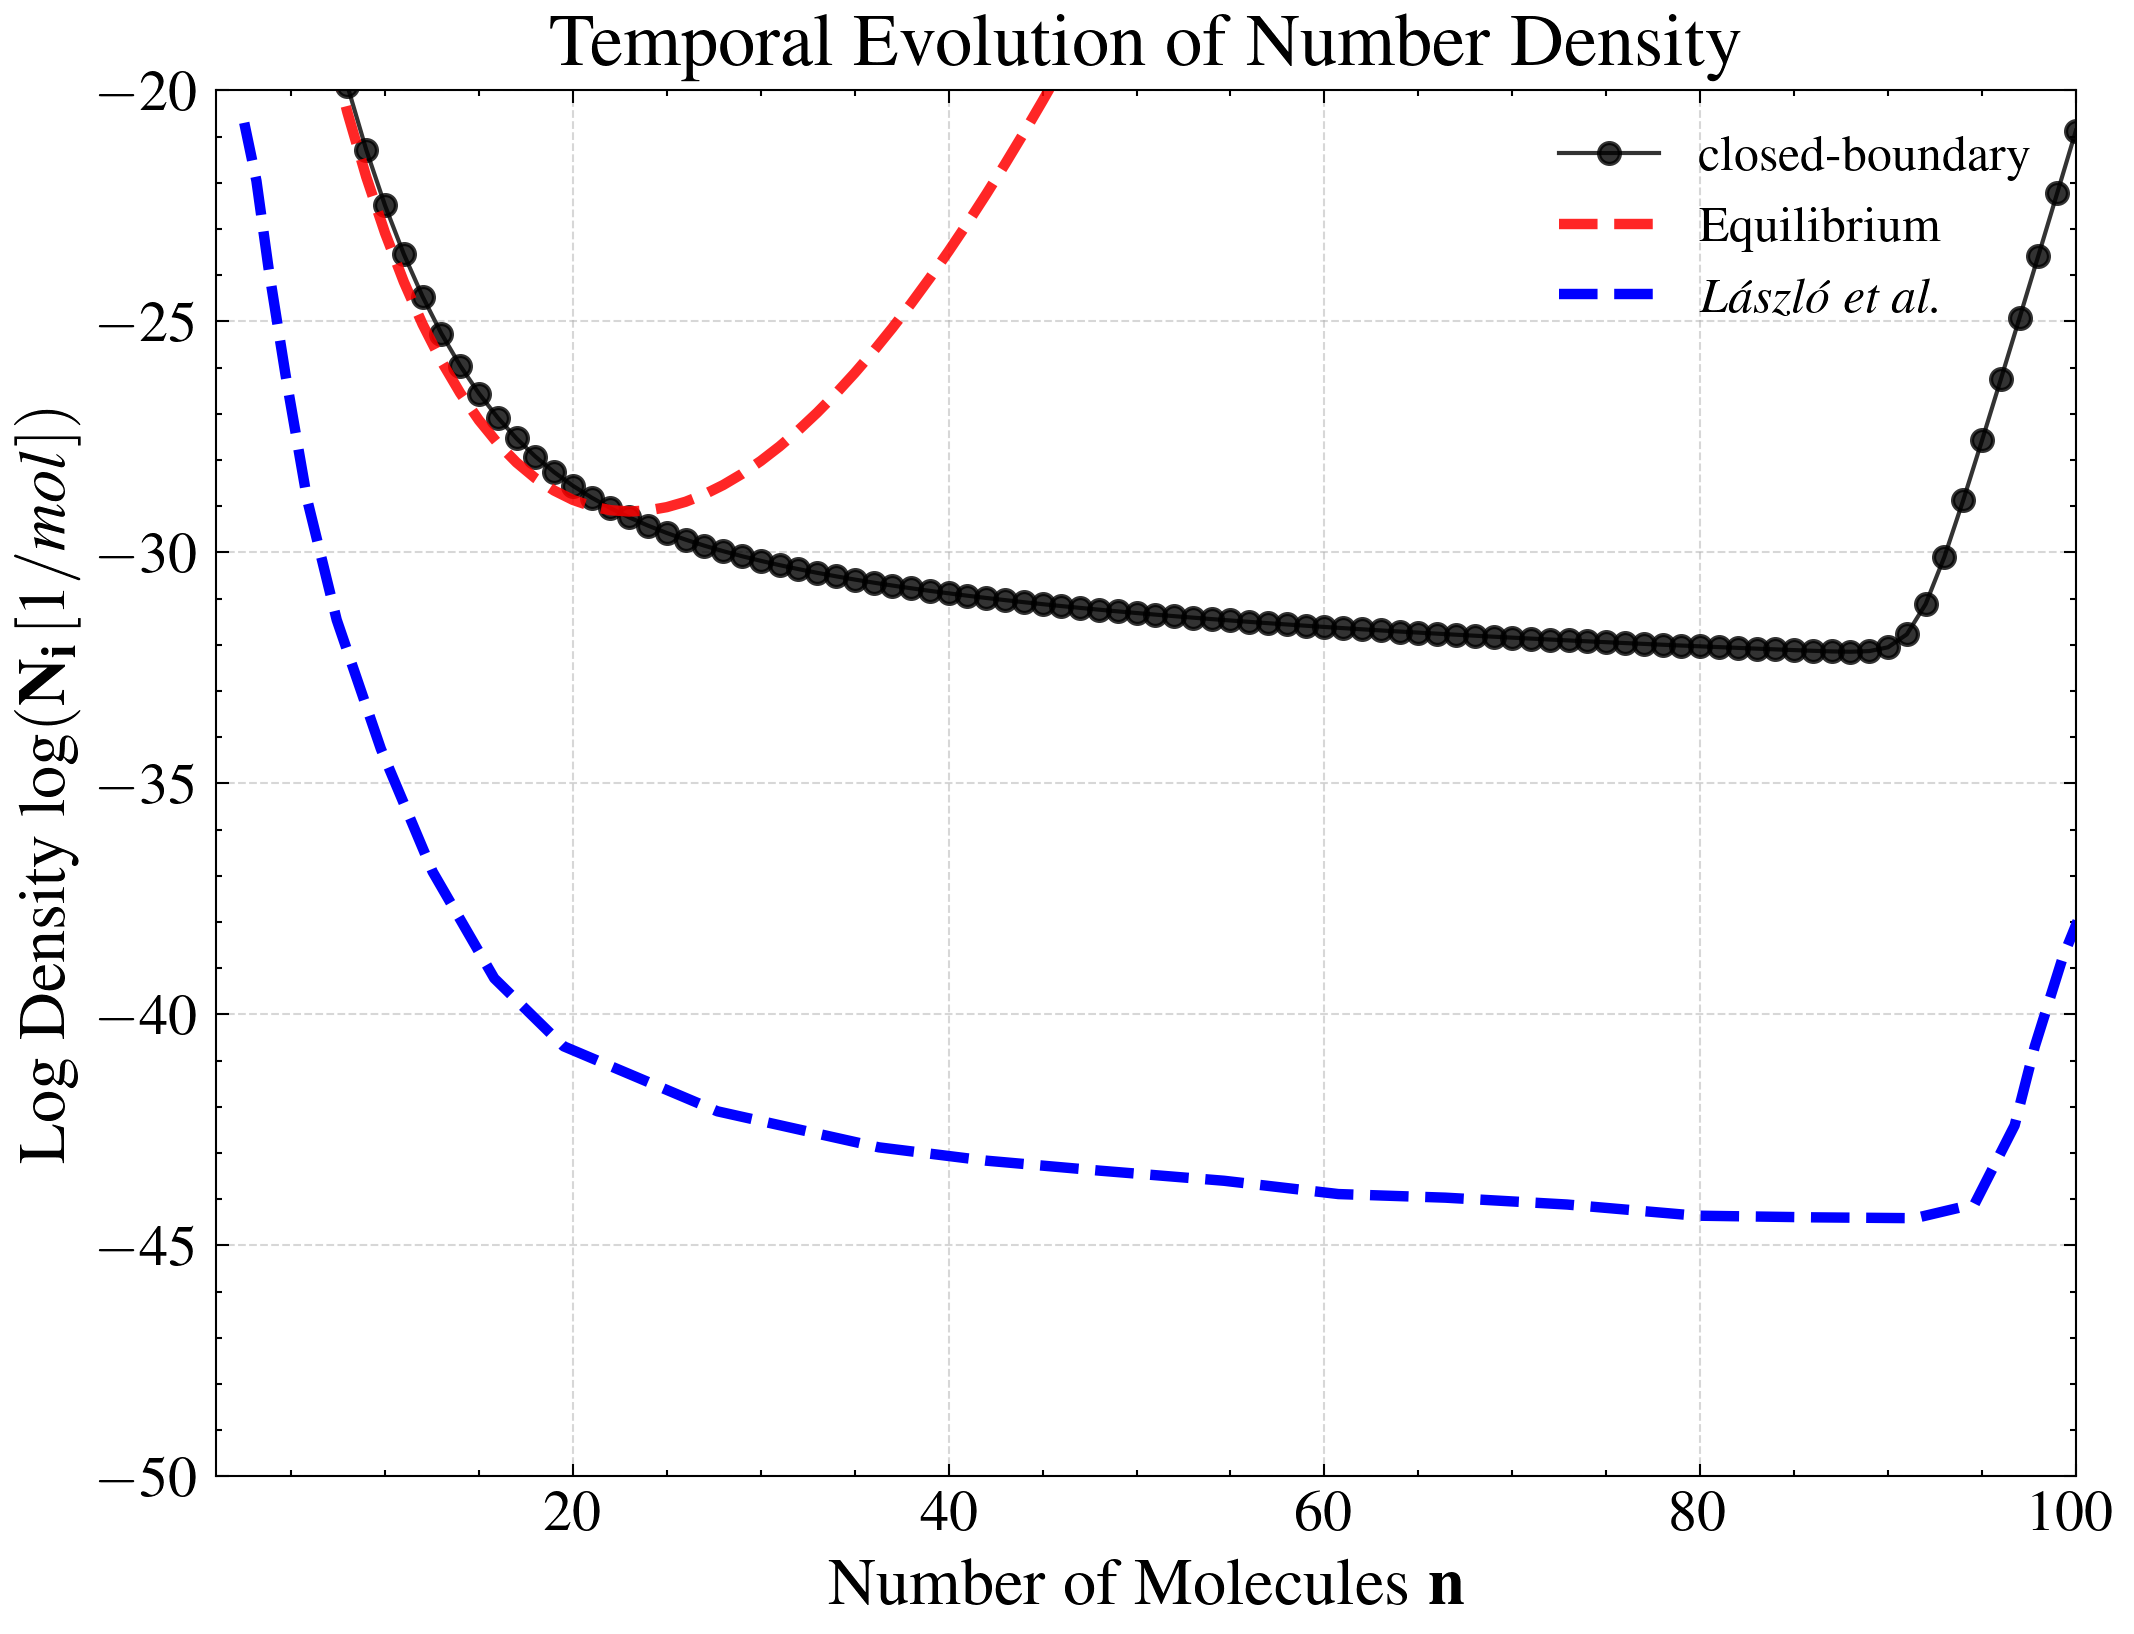

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Definiciones previas omitidas para brevedad

# Creación de la figura y ajuste de tamaño para alta calidad de impresión
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Carga de datos
df = pd.read_csv('data/lithium_disillicate_100n_laszlo.csv')

# Definir el rango de números de moléculas
number_molecules_array = np.arange(1, MAX_NUMBER_MOLECULES + 1)
        
plt.plot(number_molecules_array, np.log(sim.cluster_array[:, -1] / 6.022e23),
            label="closed-boundary",  marker='o', markersize=5, alpha=0.8)

# Añadir la línea de equilibrio con estilo mejorado
plt.plot(number_molecules_array, np.log(cluster_physics.number_density_equilibrium(number_molecules_array).magnitude / cluster_physics.AVOGADRO.magnitude),
         label="Equilibrium", color='red', alpha=0.85, linestyle='--', linewidth=2.5)

# Añadir la línea de equilibrio con estilo mejorado
plt.plot(df['X'], df['Y'],
         label=r'\textit{László et al.}', color='blue', linestyle='--', linewidth=2.5)


# Ajustes finales de etiquetas y títulos con calidad de publicación
plt.xlabel(r"Number of Molecules $\mathbf{n}$", fontsize=16)
plt.ylabel(r"Log Density $\log(\mathbf{N_i} \, [1/mol])$", fontsize=16)
plt.title("Temporal Evolution of Number Density", fontsize=18)
plt.legend(fontsize=12, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1, MAX_NUMBER_MOLECULES)
plt.ylim(-50, -20)
plt.yticks(np.arange(-50, -19, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Ligera cuadrícula para mejorar la lectura

plt.show()


In [5]:
sim = nd.JuliaClusterDynamics(path,int(1e8),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method = de.Tsit5(), rtol = 1e-5, atol = 1e-5)


NameError: name 'de' is not defined

In [5]:
sim = nd.ScipyClusterDynamics(path,int(2e5),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method=Pr7, t_eval=None, rtol=1e-9, atol=1e-9, max_step = 2*dt)

/home/alexandre_sureda/miniconda3/envs/neutronics/lib/python3.11/site-packages/extensisq/common.py:452: UserWarning: Your problem has a real dominant root and is diagnosed as stiff.  You should probably change to a code intended for stiff problems.
  warn('Your problem has a real dominant root '


{'execution_time': 24.1949520111084, 'success': True, 'nfev': 1760033}


In [11]:
t_span = (0.0, dt*int(steps))

t_eval = [dt, 10*dt, 1e2*dt, 1e3*dt, 1e4*dt, 1e5*dt]

In [12]:
t_eval = np.linspace(*t_span, int(1e5))
sim = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method='Radau', t_eval=t_eval, rtol=1e-8, atol=1e-8)

sim2 = nd.ScipyClusterDynamics(path,int(steps),dt, number_clusters_start, MAX_NUMBER_MOLECULES, boundary_type="open")
sim2.simulate(method='Radau', t_eval=t_eval, rtol=1e-8, atol=1e-8)



{'execution_time': 1.8857345581054688, 'success': True, 'nfev': 11848}
{'execution_time': 1.8709442615509033, 'success': True, 'nfev': 11750}


In [36]:
cluster_physics.unbiased_jump_rate

1.1384552476603375e-06 <Unit('1 / second')>

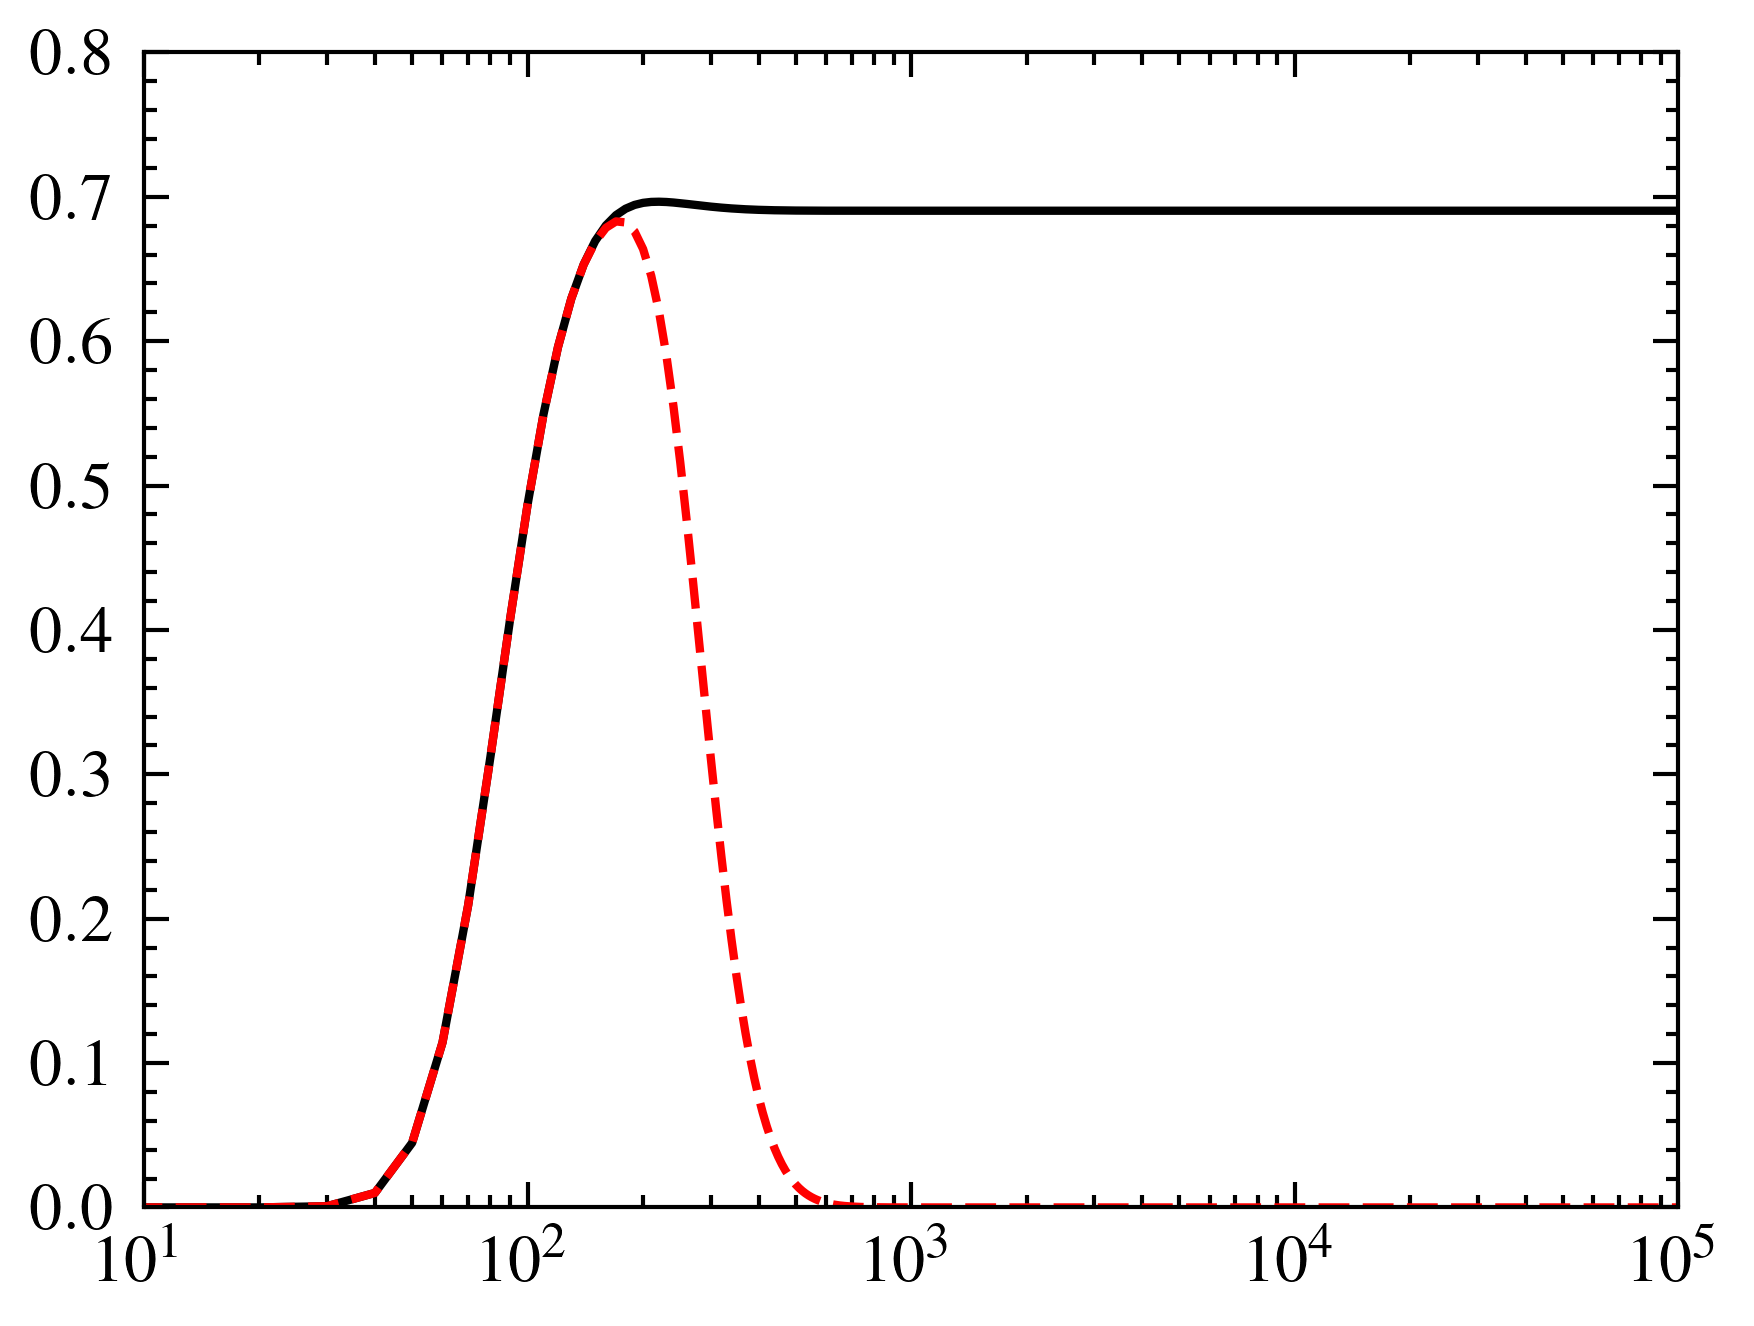

In [7]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(sim.time/dt, 1e-5*sim.dydt_array[22:, :].sum(axis=0)*dt)

plt.plot(sim2.time/dt, 1e-5*sim2.dydt_array[22:, :].sum(axis=0)*dt)

##plt.yscale('log')
plt.xlim(1e1,1e5)
plt.ylim(0, 0.8)
plt.xscale('log')
#plt.yscale('log')
#plt.yscale('log')

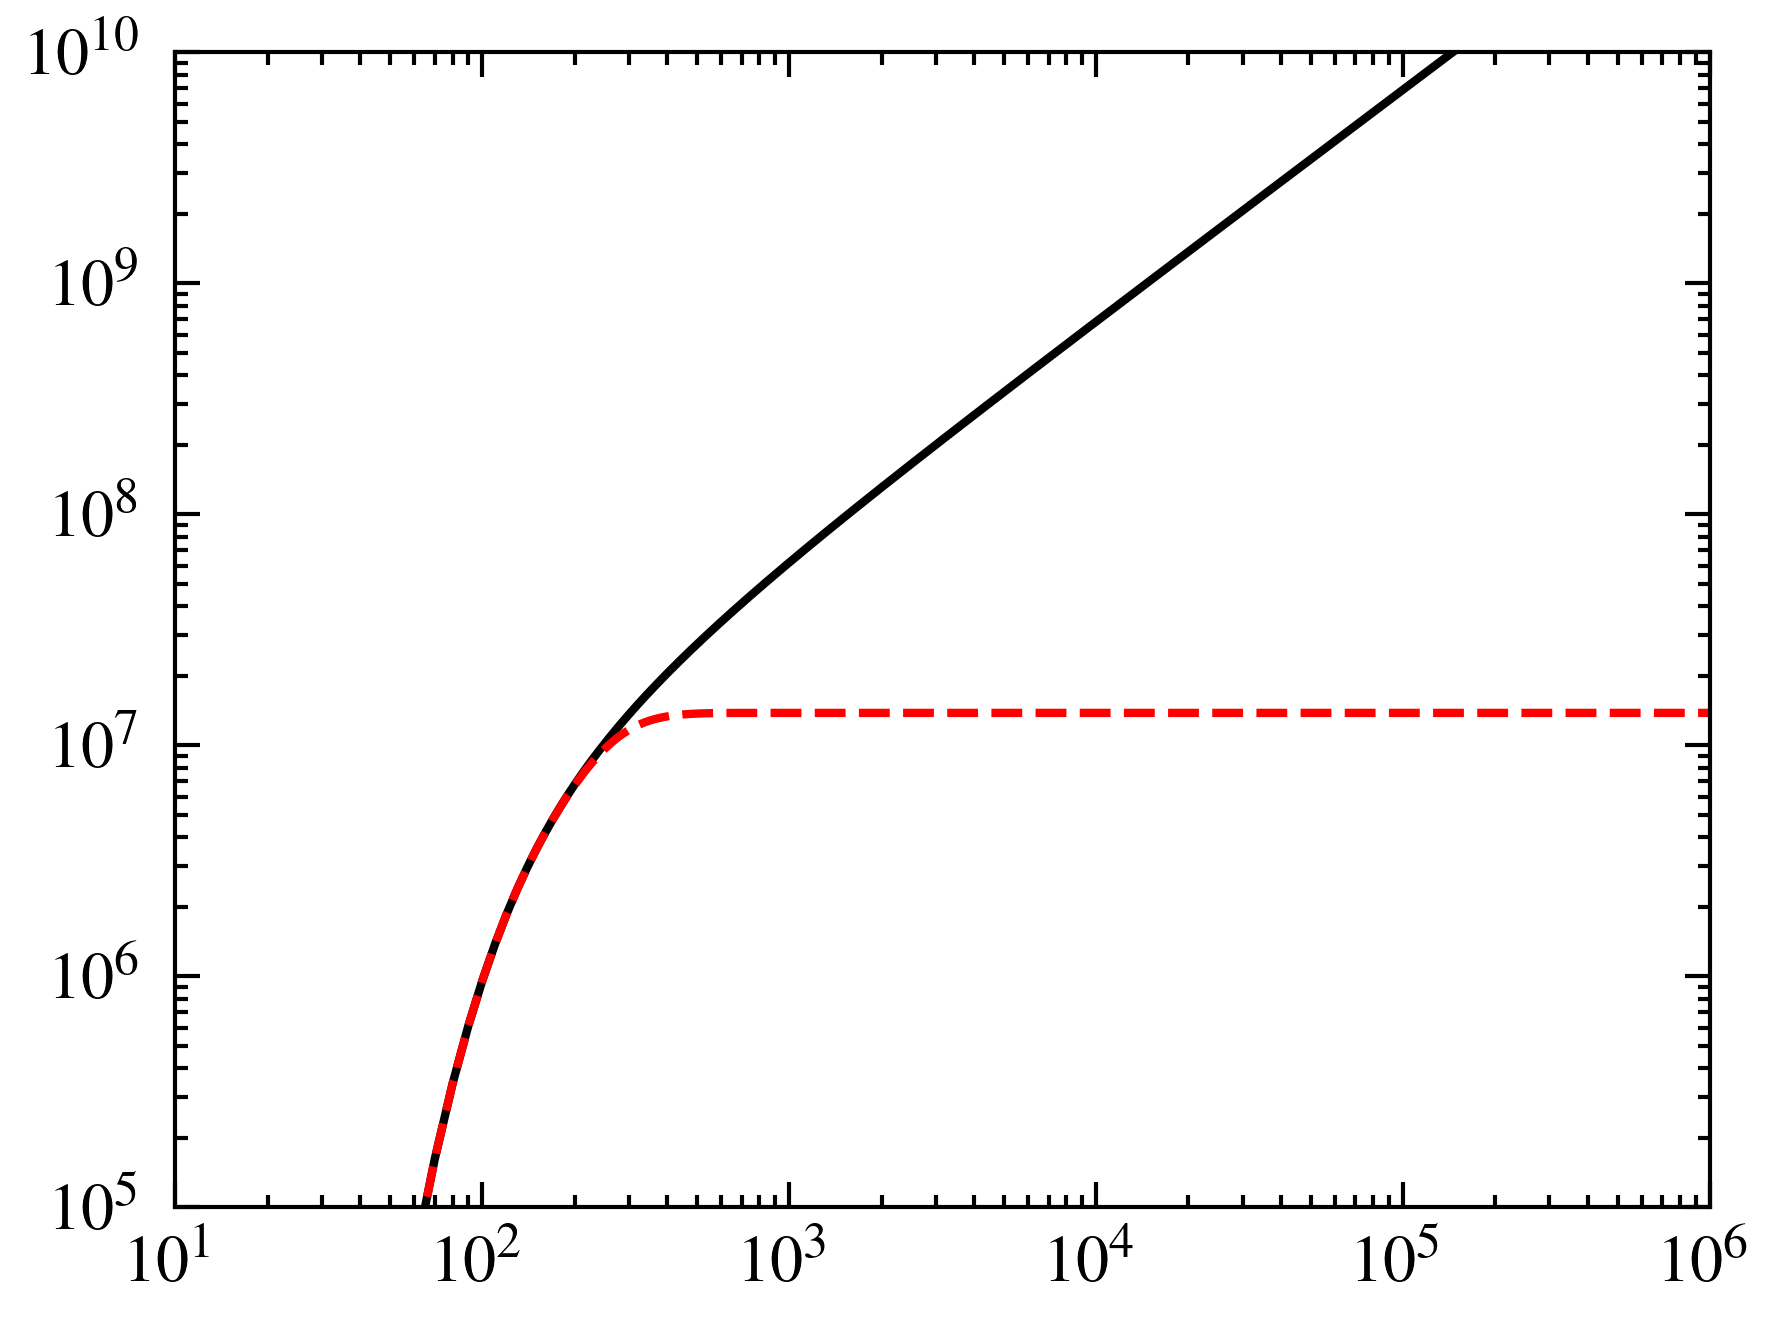

In [8]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(sim.time/dt, sim.cluster_array[23:, :].sum(axis=0))
plt.plot(sim2.time/dt, sim2.cluster_array[23:, :].sum(axis=0))

##plt.yscale('log')
plt.xlim(10,1e6)
plt.ylim(1e5,1e10)
plt.xscale('log')
plt.yscale('log')
#plt.yscale('log')

/tmp/ipykernel_25148/3460223238.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores1 = cm.get_cmap('Blues', 12)  # Más suave y profesional para el primer conjunto
/tmp/ipykernel_25148/3460223238.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colores2 = cm.get_cmap('Greens', 12)  # Contraste claro pero estético para el segundo conjunto
/tmp/ipykernel_25148/3460223238.py:43: RuntimeWarning: divide by zero encountered in log
  plt.plot(number_molecules_array, np.log(sim.cluster_array[:, idx] / 6.022e23),


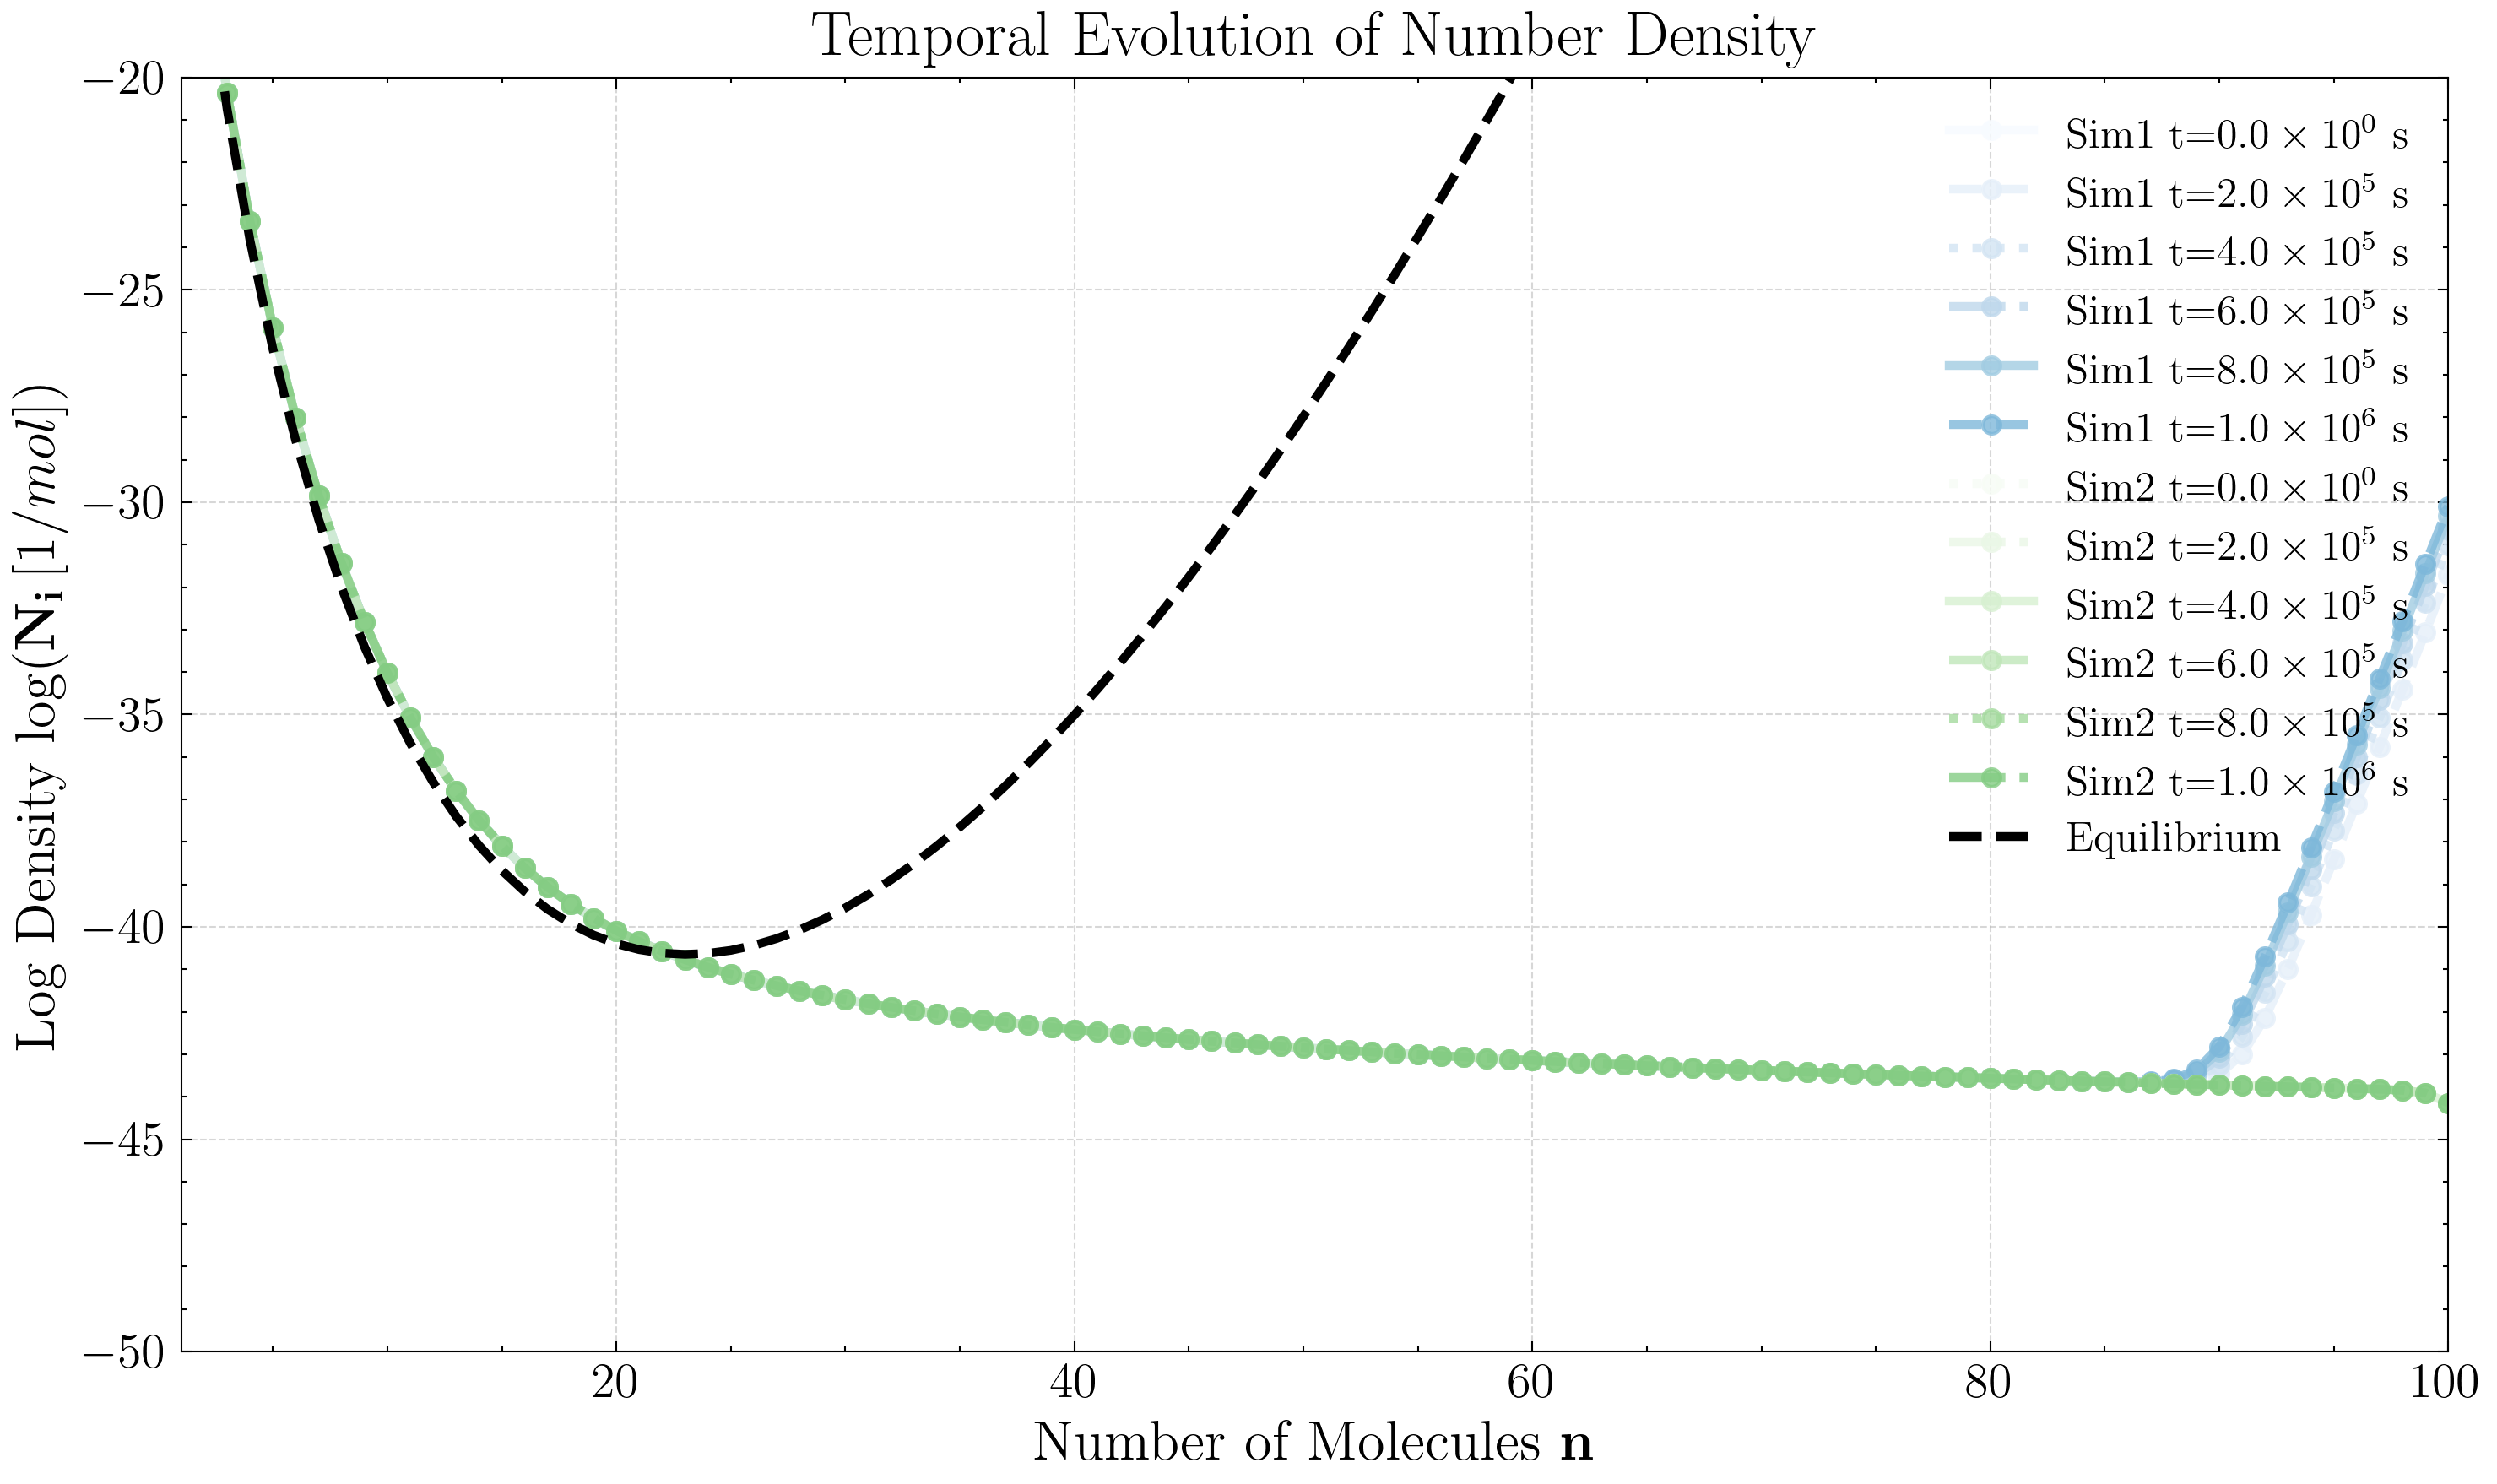

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Definiciones previas omitidas para brevedad

# Definir el rango de números de moléculas
number_molecules_array = np.arange(1, MAX_NUMBER_MOLECULES + 1)

# Mejorar la paleta de colores para una distinción clara y estética
colores1 = cm.get_cmap('Blues', 12)  # Más suave y profesional para el primer conjunto
colores2 = cm.get_cmap('Greens', 12)  # Contraste claro pero estético para el segundo conjunto

# Ajustes de estilo global mejorados para publicación
plt.rcParams.update({
    'legend.loc': 'upper right',
    'lines.linewidth': 2.5,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],  # Preferido por muchas revistas científicas
    'figure.figsize': (10, 6),
    'figure.dpi': 300,
    'legend.fontsize': 12,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.autolayout': True,
    'text.usetex': True  # Para calidad de publicación; asegúrate de que LaTeX esté instalado
})

def plot_results(sim, colores, label_prefix):
    # Selecciona puntos de tiempo equiespaciados para mostrar
    num_points = 6
    indices = np.linspace(0, len(sim.time) - 1, num_points, dtype=int)

    for i, idx in enumerate(indices):
        time_in_s = sim.time[idx] / dt # cluster_physics.unbiased_jump_rate.magnitude
        mantisa, exponente = f"{time_in_s:.1e}".split('e')
        exponente = int(exponente)
        time_formatted = r"${} \times 10^{{{}}}$".format(mantisa, exponente)
        label = f"{label_prefix} t={time_formatted} s"
        
        plt.plot(number_molecules_array, np.log(sim.cluster_array[:, idx] / 6.022e23),
                 label=label, color=colores(i), marker='o', markersize=5, alpha=0.8)

# Llamar a la función para cada conjunto de resultados con mejoras visuales
plot_results(sim, colores1, "Sim1")
plot_results(sim2, colores2, "Sim2")

# Añadir la línea de equilibrio con estilo mejorado
plt.plot(number_molecules_array, np.log(cluster_physics.number_density_equilibrium(number_molecules_array).magnitude / cluster_physics.AVOGADRO.magnitude),
         label="Equilibrium", color='black', linestyle='--', linewidth=2.5)

# Ajustes finales de etiquetas y títulos con calidad de publicación
plt.xlabel(r"Number of Molecules $\mathbf{n}$", fontsize=16)
plt.ylabel(r"Log Density $\log(\mathbf{N_i} \, [1/mol])$", fontsize=16)
plt.title("Temporal Evolution of Number Density", fontsize=18)
plt.legend(fontsize=12, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(1, MAX_NUMBER_MOLECULES)
plt.ylim(-50, -20)
plt.yticks(np.arange(-50, -19, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Ligera cuadrícula para mejorar la lectura

plt.show()


In [5]:
#time_step_array = [int(1e5), int(2e5), int(3e5), int(4e5), int(5e5)]
time_step_array = [int(1e3),int(5e3), int(1e4),int(5e4), int(1e6)]

x_array = []
y_array = []
for ts in time_step_array:
    sim = nd.ScipyClusterDynamics(params,ts,dt, number_clusters_start, MAX_NUMBER_MOLECULES)
    sim.simulate()
    x = sim.number_molecules_array
    y = sim.cluster_array[:,-1]
    x_array.append(x)
    y_array.append(y)

Computation time: 0.0337 seconds
Computation time: 0.0521 seconds
Computation time: 0.1762 seconds
Computation time: 1.0776 seconds
Computation time: 29.4072 seconds


/tmp/ipykernel_8295/967383811.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
/tmp/ipykernel_8295/967383811.py:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))


(-50.0, -20.0)

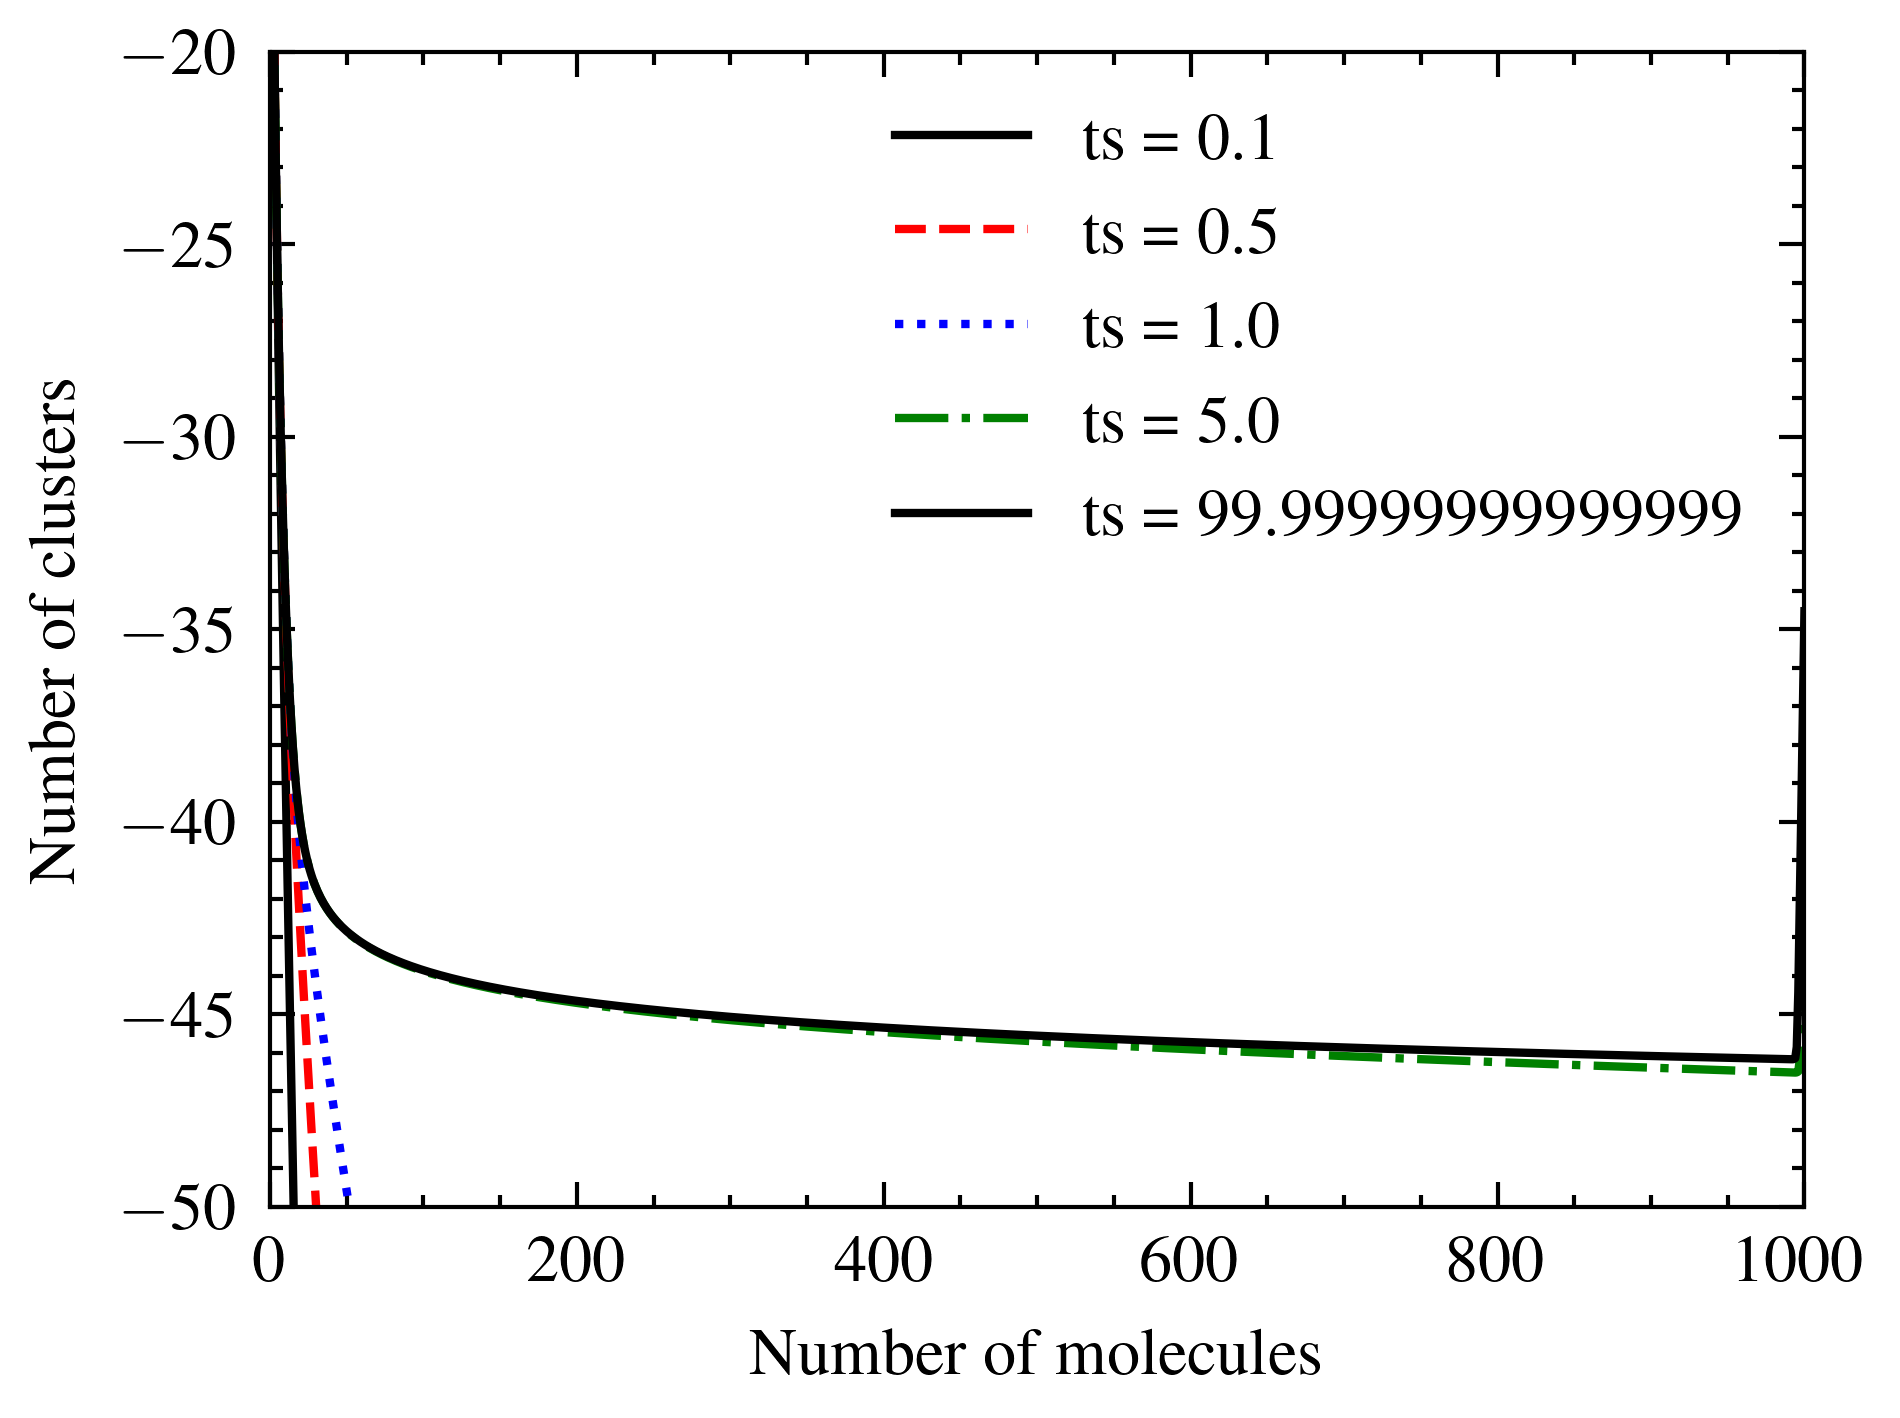

In [6]:
plt.figure()
n = np.linspace(1,1000,1000)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,1000)
plt.ylim(-50,-20)

In [5]:
#time_step_array = [int(1e5), int(2e5), int(3e5), int(4e5), int(5e5)]
time_step_array = [int(1e3),int(5e3), int(1e4),int(5e4), int(1e6)]

x_array = []
y_array = []
for ts in time_step_array:
    sim = nd.OpenClusterDynamics(params,ts,dt, number_clusters_start, MAX_NUMBER_MOLECULES, record_frequency=5)
    sim.simulate()
    x = sim.number_molecules_array
    y = sim.cluster_evolution[:,-1]
    x_array.append(x)
    y_array.append(y)

Computation time: 1.6886 seconds
Computation time: 0.2698 seconds
Computation time: 0.4434 seconds
Computation time: 2.2021 seconds
Computation time: 33.2245 seconds


/tmp/ipykernel_9375/967383811.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))


(-50.0, -20.0)

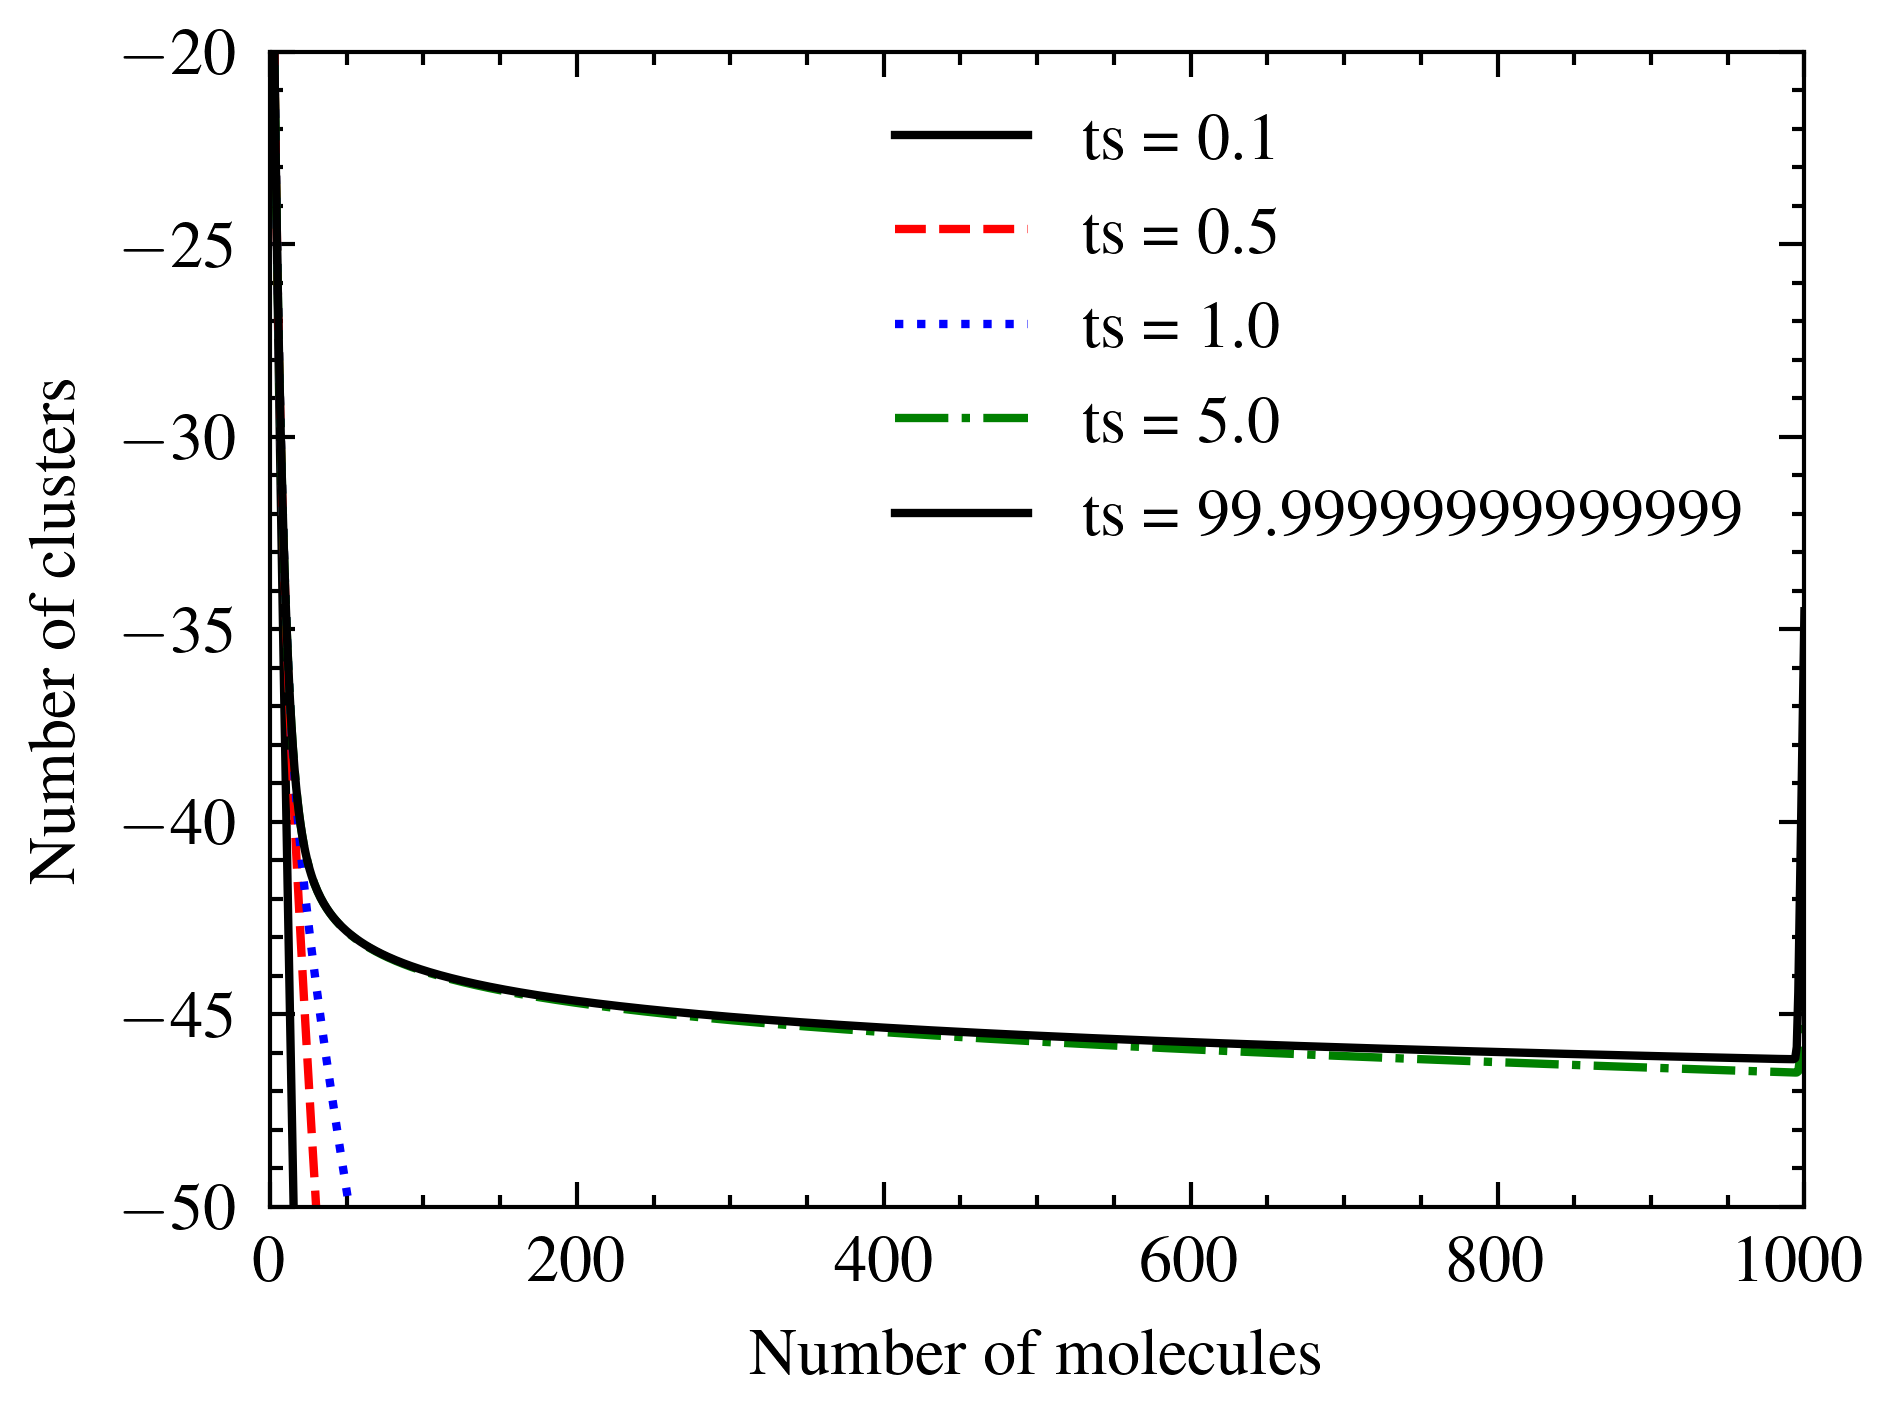

In [8]:
plt.figure()
n = np.linspace(1,1000,1000)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
#plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,1000)
plt.ylim(-50,-20)

In [11]:
#time_step_array = [int(1e5), int(2e5), int(3e5), int(4e5), int(5e5)]
time_step_array = [int(1e5)]

x_array = []
y_array = []
for ts in time_step_array:
    sim = nd.ClosedClusterDynamics(params,ts,dt, number_clusters_start, MAX_NUMBER_MOLECULES, record_frequency=1)
    sim.simulate()
    x = sim.number_molecules_array
    y = sim.cluster_evolution[:,-1]
    x_array.append(x)
    y_array.append(y)

: 

In [9]:
sim.cluster_evolution

array([[5.85658411e+18, 5.85060004e+18, 5.84661418e+18, ...,
                   nan,            nan,            nan],
       [3.16539427e+16, 3.33864363e+16, 3.45252010e+16, ...,
                   nan,            nan,            nan],
       [2.27490565e+14, 3.95465192e+14, 5.18861415e+14, ...,
                   nan,            nan,            nan],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan]])

(0.0, 10000.0)

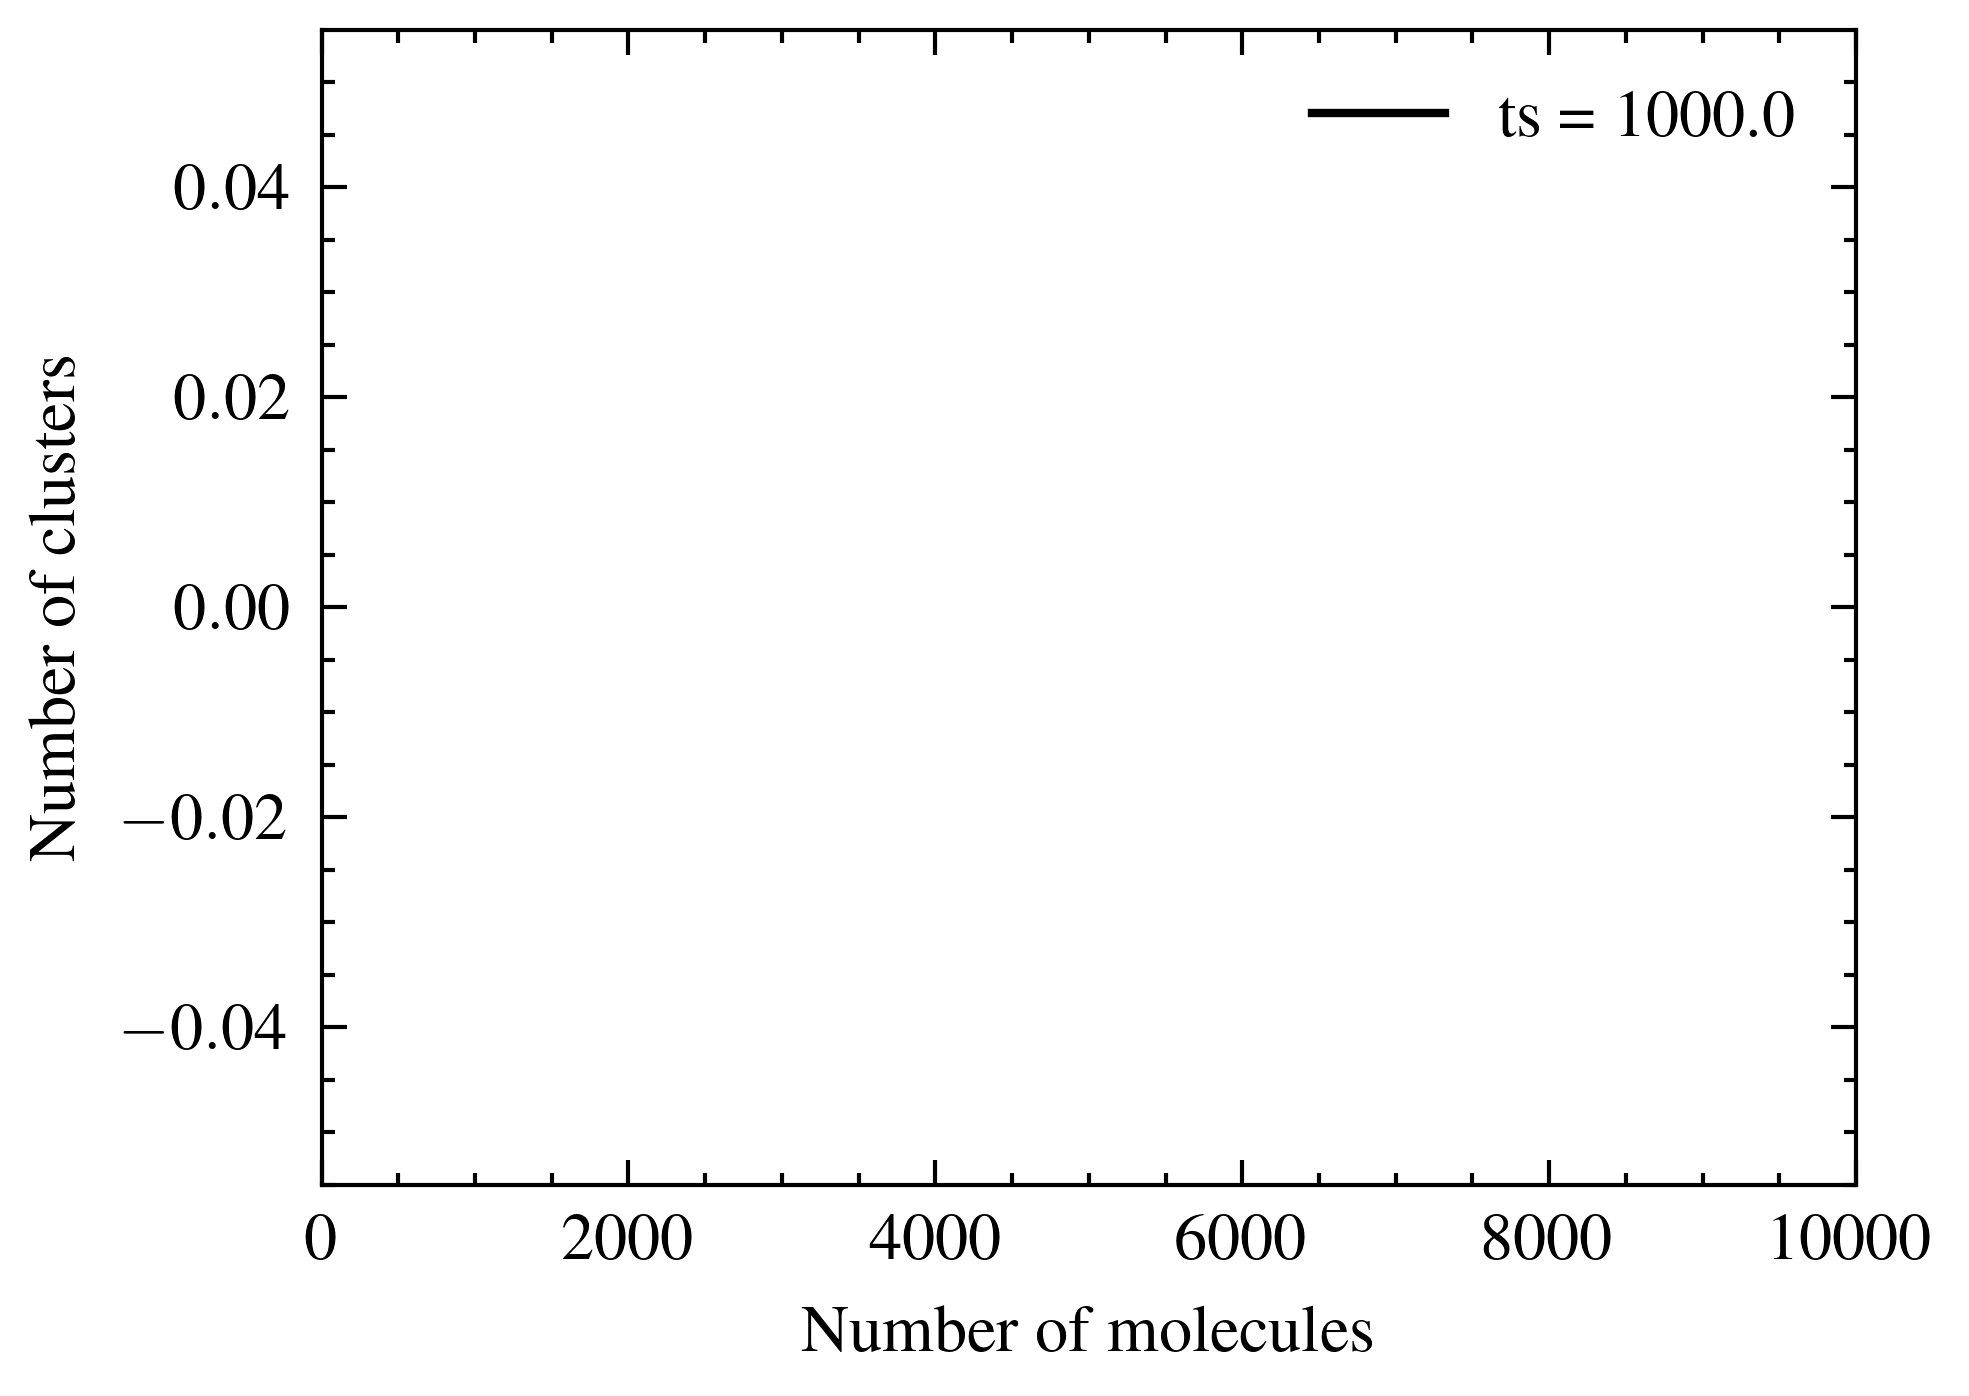

In [8]:
plt.figure()
n = np.linspace(1,100,100)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],np.log(sim.cluster_evolution[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
#plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,10000)
#plt.ylim(-50,-20)

In [7]:
#With Numba 

""" 
# Ejemplo de uso de la clase
params = {
    'temperature': 750,
    'activation_energy': 59920.2,
    'diffusivity_factor': 2e-9,
    'jump_distance': 4.6e-10,
    'molar_mass': 150.05,
    'mass_density': 2.5,
    'melting_point': 1300,
    'heat_fusion': 52 * 1e3,
    'supersaturation_ratio': 20.5,
    'sigma': 0.15, 
    'method': 'melting'
}

Computation time: 1.4030 seconds
Computation time: 0.0169 seconds
Computation time: 0.1812 seconds
Computation time: 0.8422 seconds
 """

 # Without Numba
""" 
Computation time: 0.0014 seconds
Computation time: 0.0812 seconds
Computation time: 0.8159 seconds
Computation time: 4.1370 seconds 
"""

' \nComputation time: 0.0014 seconds\nComputation time: 0.0812 seconds\nComputation time: 0.8159 seconds\nComputation time: 4.1370 seconds \n'

In [6]:
steady_state = sim.compute_analytical_steady_state()

(-50.0, -20.0)

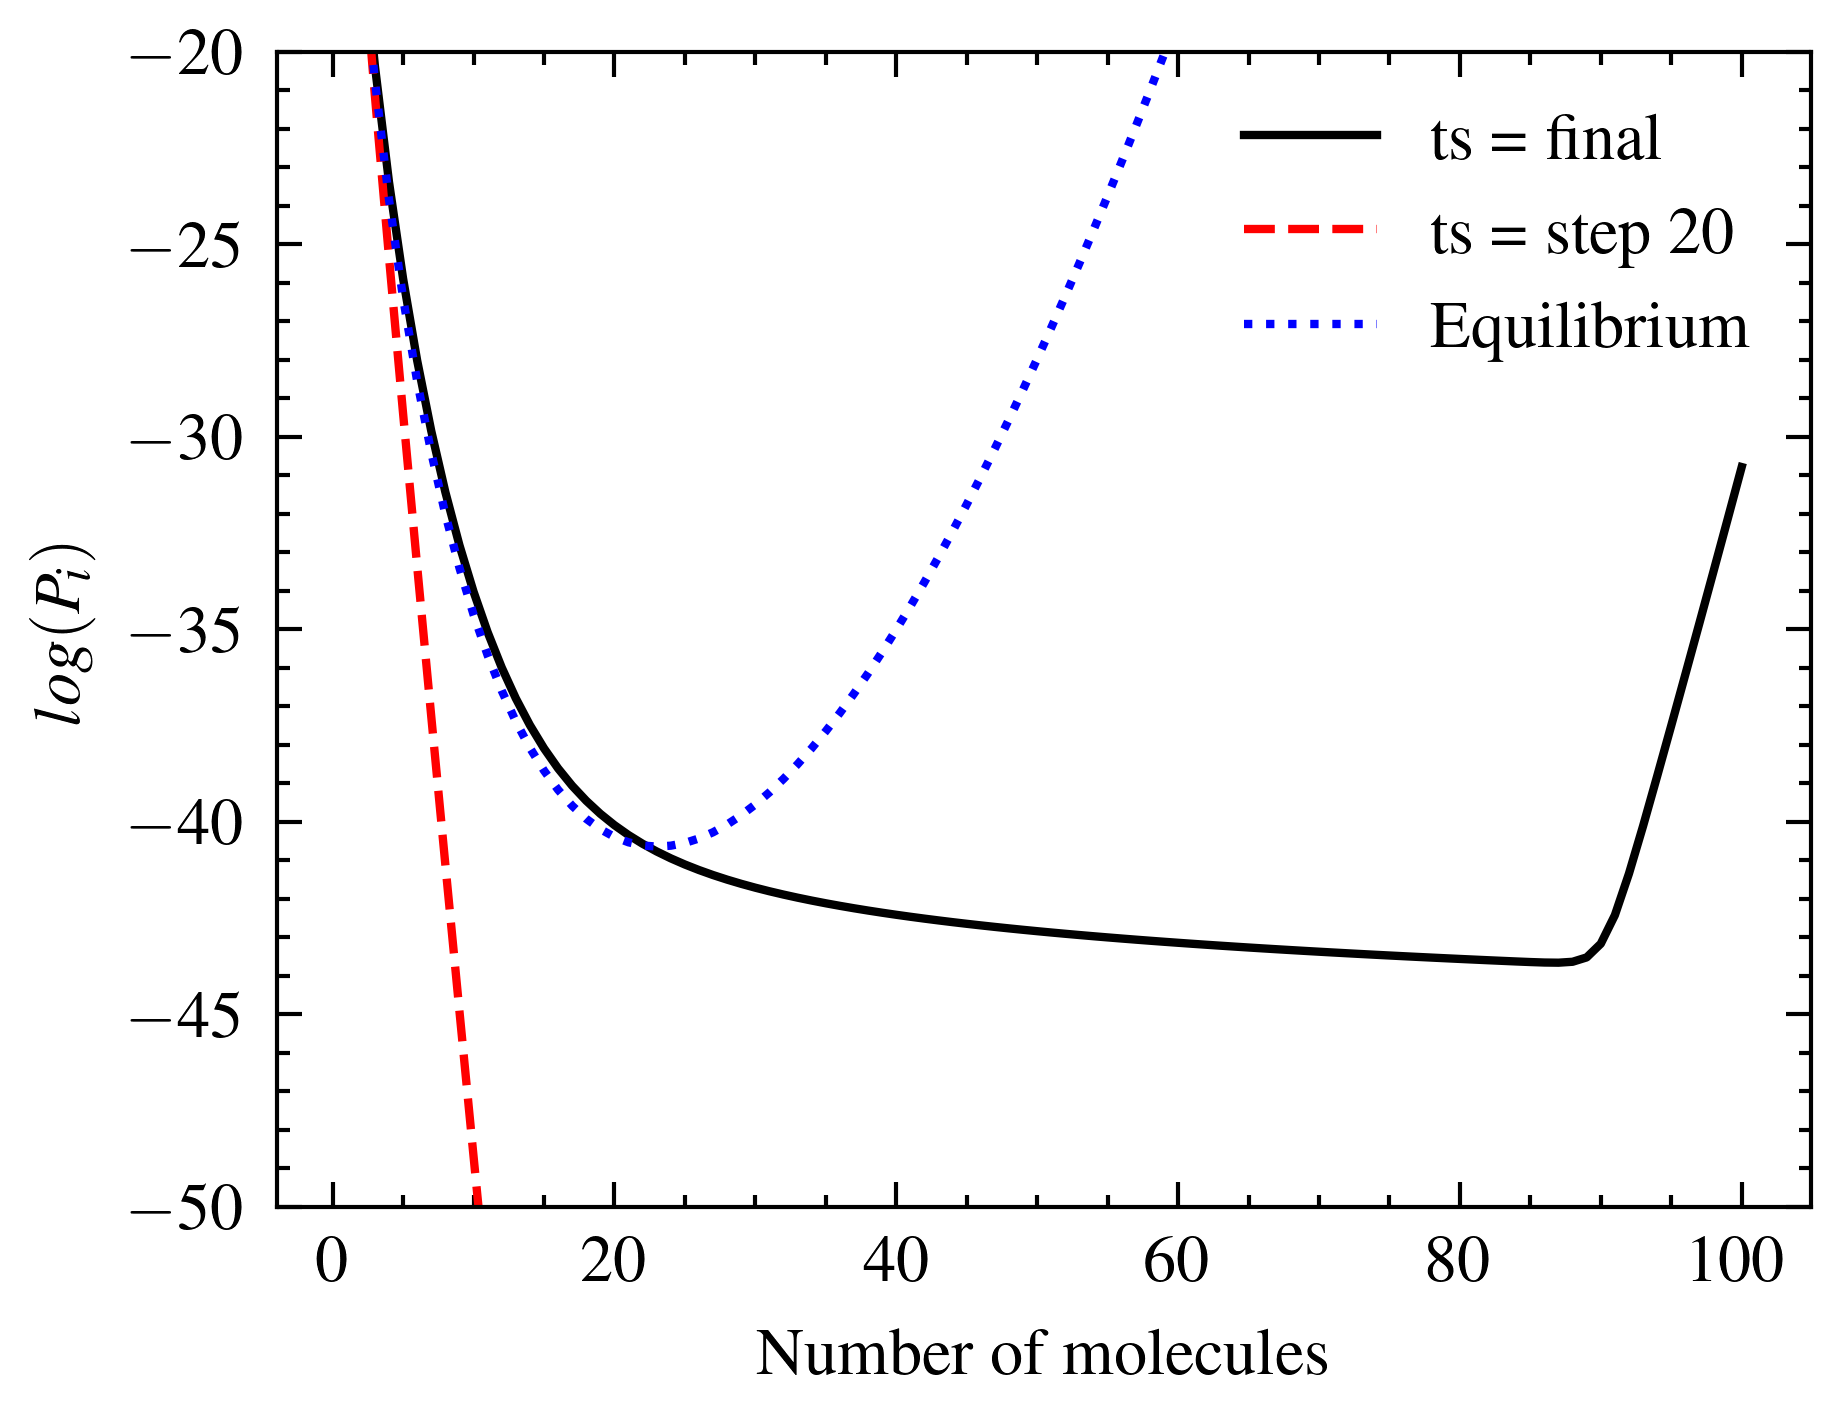

In [8]:

plt.figure()
n = np.linspace(1,100,100)
plt.plot(sim.number_molecules_array,np.log(sim.cluster_array[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = final')
plt.plot(sim.number_molecules_array,np.log(sim.cluster_array[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')
    #plt.plot(x_array[i],np.log(sim.cluster_evolution[:,100]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))

plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel(r'$log(P_i)$')
#plt.xlim(1,MAX_NUMBER_MOLECULES)
plt.ylim(-50,-20)


(-50.0, -20.0)

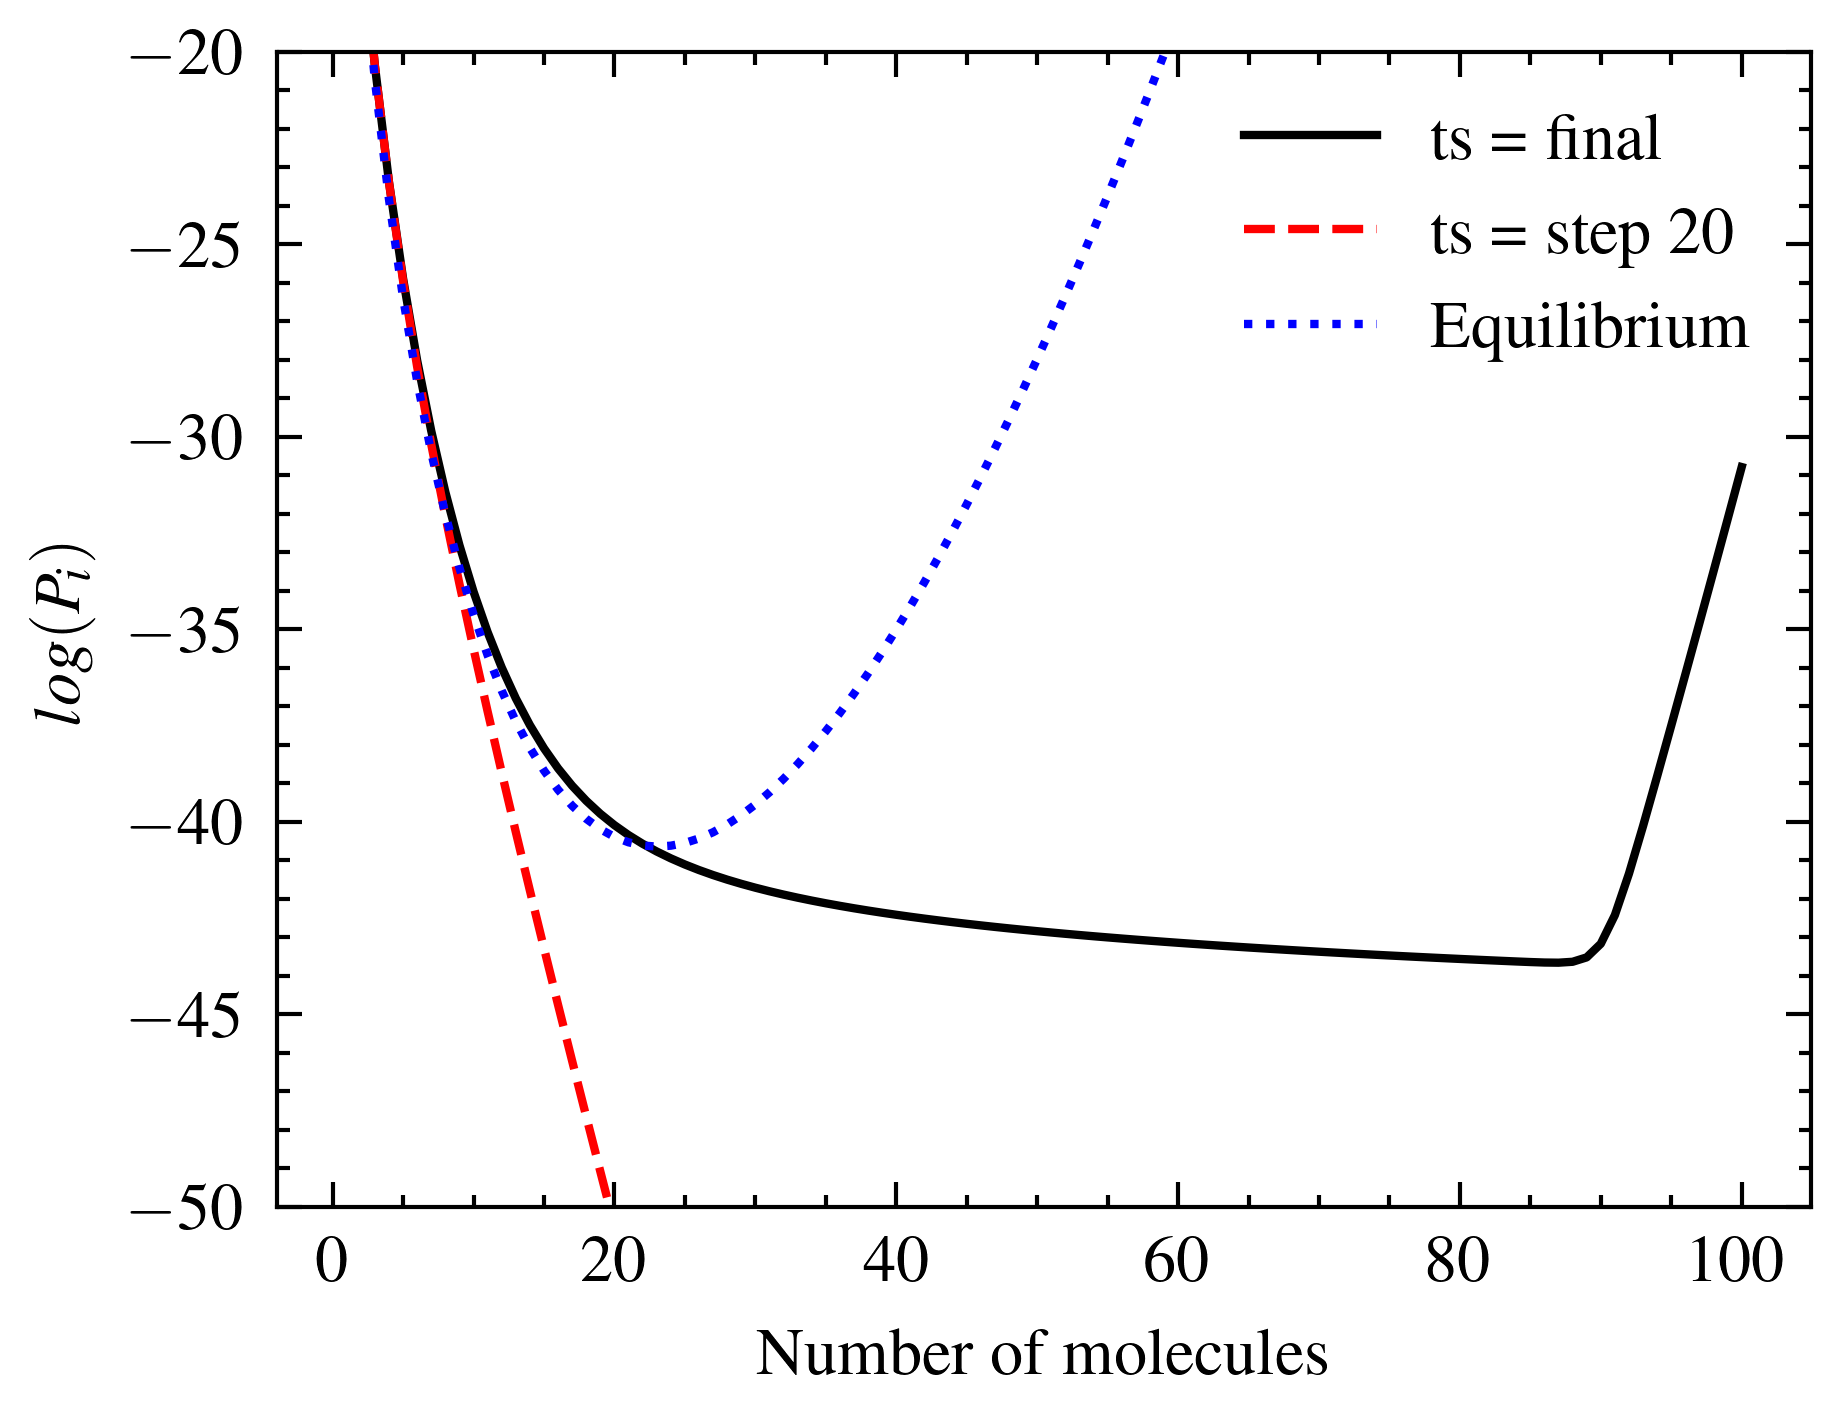

In [6]:
plt.figure()
n = np.linspace(1,100,100)
plt.plot(sim.number_molecules_array,np.log(sim.cluster_evolution[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = final')
plt.plot(sim.number_molecules_array,np.log(sim.cluster_evolution[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')
    #plt.plot(x_array[i],np.log(sim.cluster_evolution[:,100]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))

plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel(r'$log(P_i)$')
#plt.xlim(1,MAX_NUMBER_MOLECULES)
plt.ylim(-50,-20)


/tmp/ipykernel_31535/2729006377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(sim2.number_molecules_array,np.log(sim2.cluster_evolution[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')


(-50.0, -20.0)

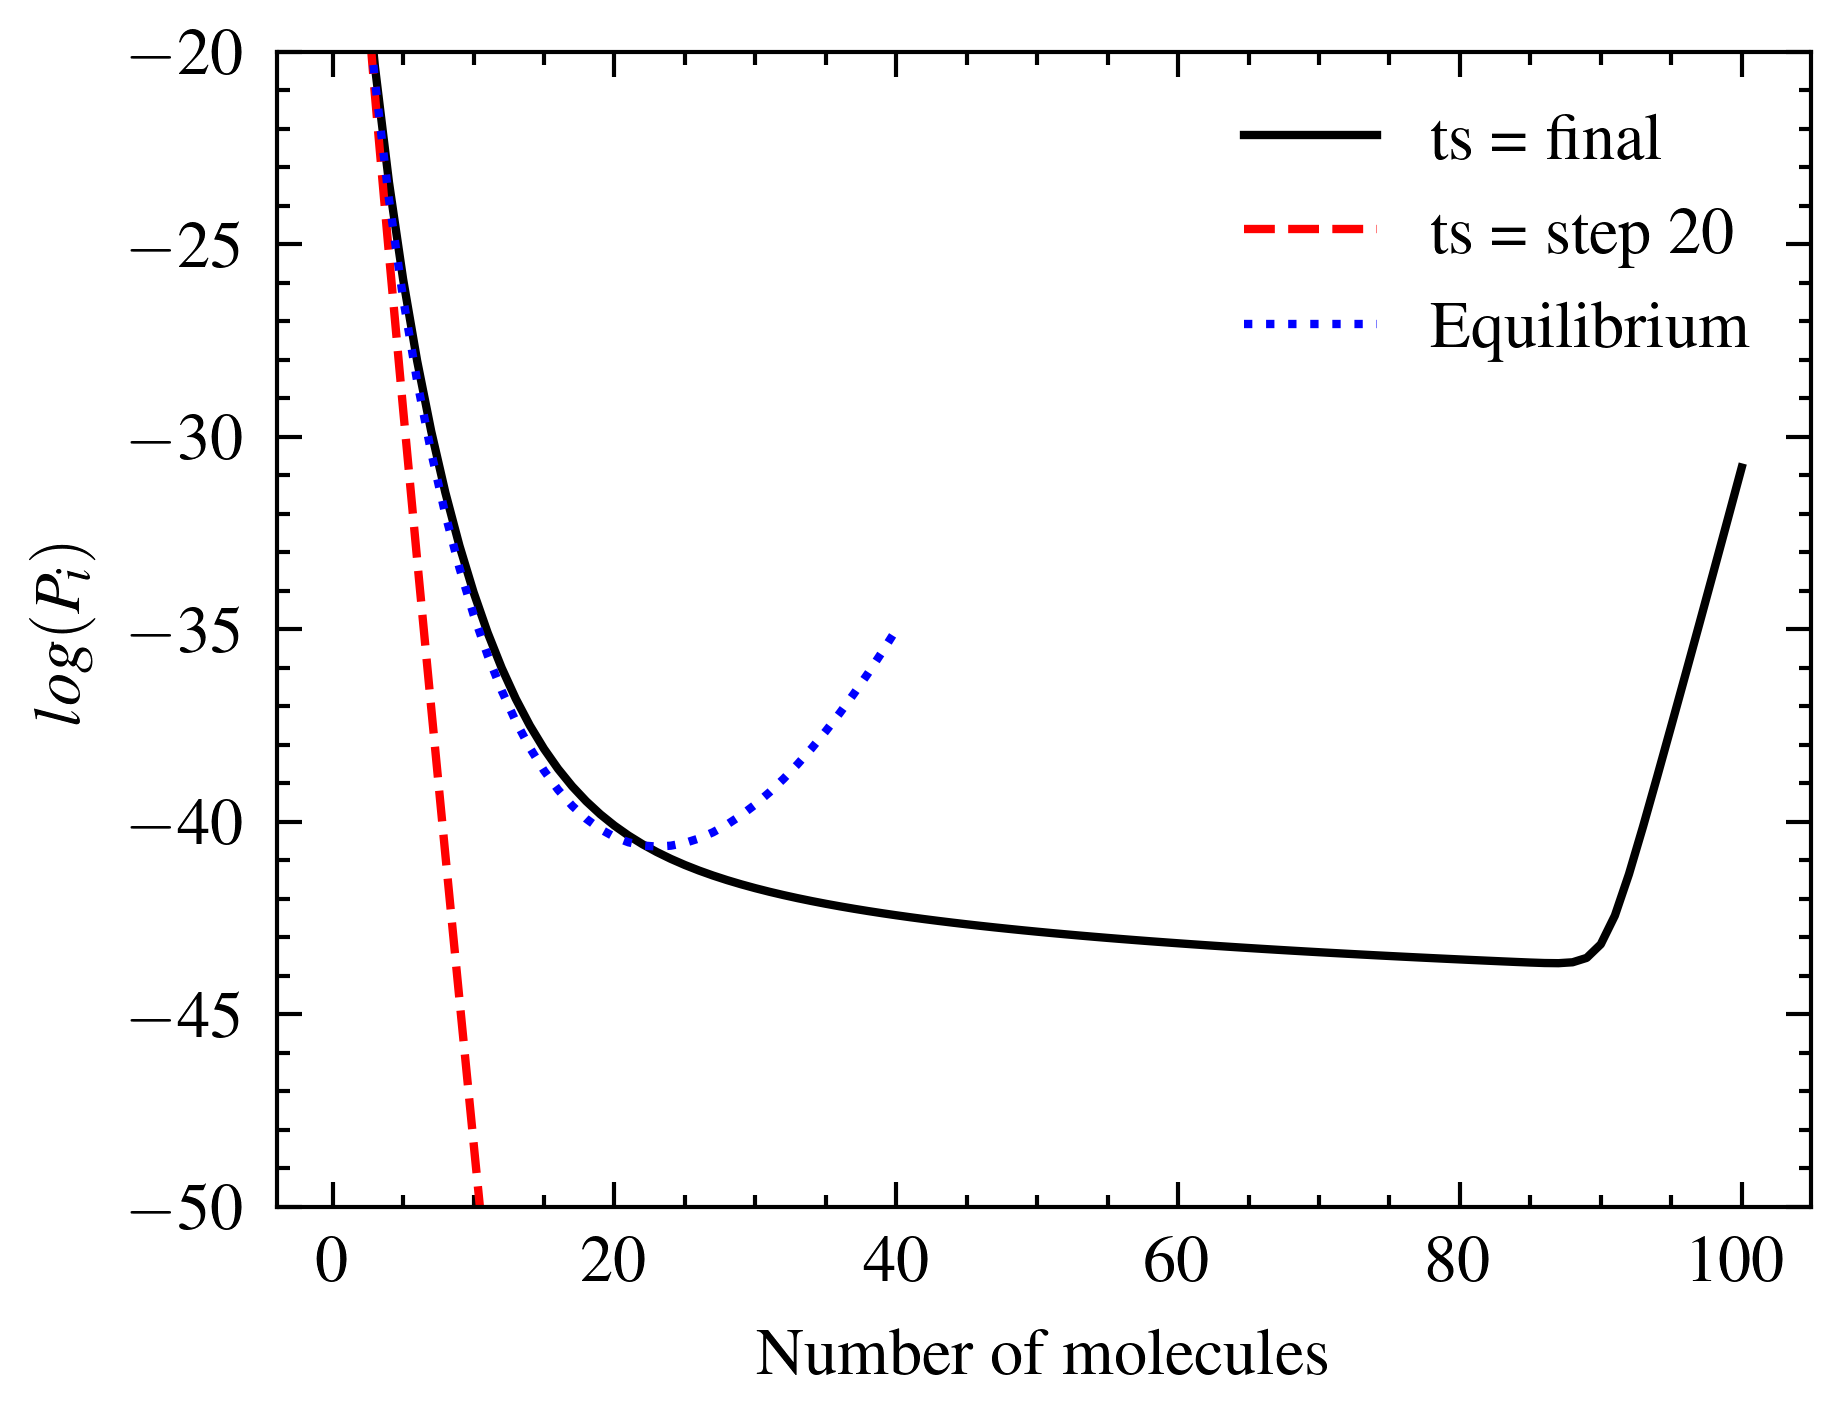

In [8]:
plt.figure()
n = np.linspace(1,40,40)
plt.plot(sim2.number_molecules_array,np.log(sim2.cluster_evolution[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = final')
plt.plot(sim2.number_molecules_array,np.log(sim2.cluster_evolution[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')
    #plt.plot(x_array[i],np.log(sim.cluster_evolution[:,100]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))

plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel(r'$log(P_i)$')
#plt.xlim(1,MAX_NUMBER_MOLECULES)
plt.ylim(-50,-20)


In [9]:
plt.figure()
plt.plot(sim.cluster_evolution[10,:], label = 'N=9')
plt.plot(sim.cluster_evolution[20,:], label = 'N=19')
plt.plot(sim.cluster_evolution[39,:], label = 'N=40')

plt.legend()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Number of clusters')
plt.show()

: 

In [6]:
sim.cluster_evolution

array([[6.02214090e+23, 6.02214090e+23, 6.02214090e+23, ...,
        6.02214090e+23, 6.02214090e+23, 6.02214090e+23],
       [2.95378152e+21, 2.97098365e+21, 2.98782561e+21, ...,
        3.79638202e+21, 3.79638202e+21, 3.79638202e+21],
       [2.67973215e+16, 1.35676791e+18, 2.66750455e+18, ...,
        8.81199288e+19, 8.81199288e+19, 8.81199288e+19],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

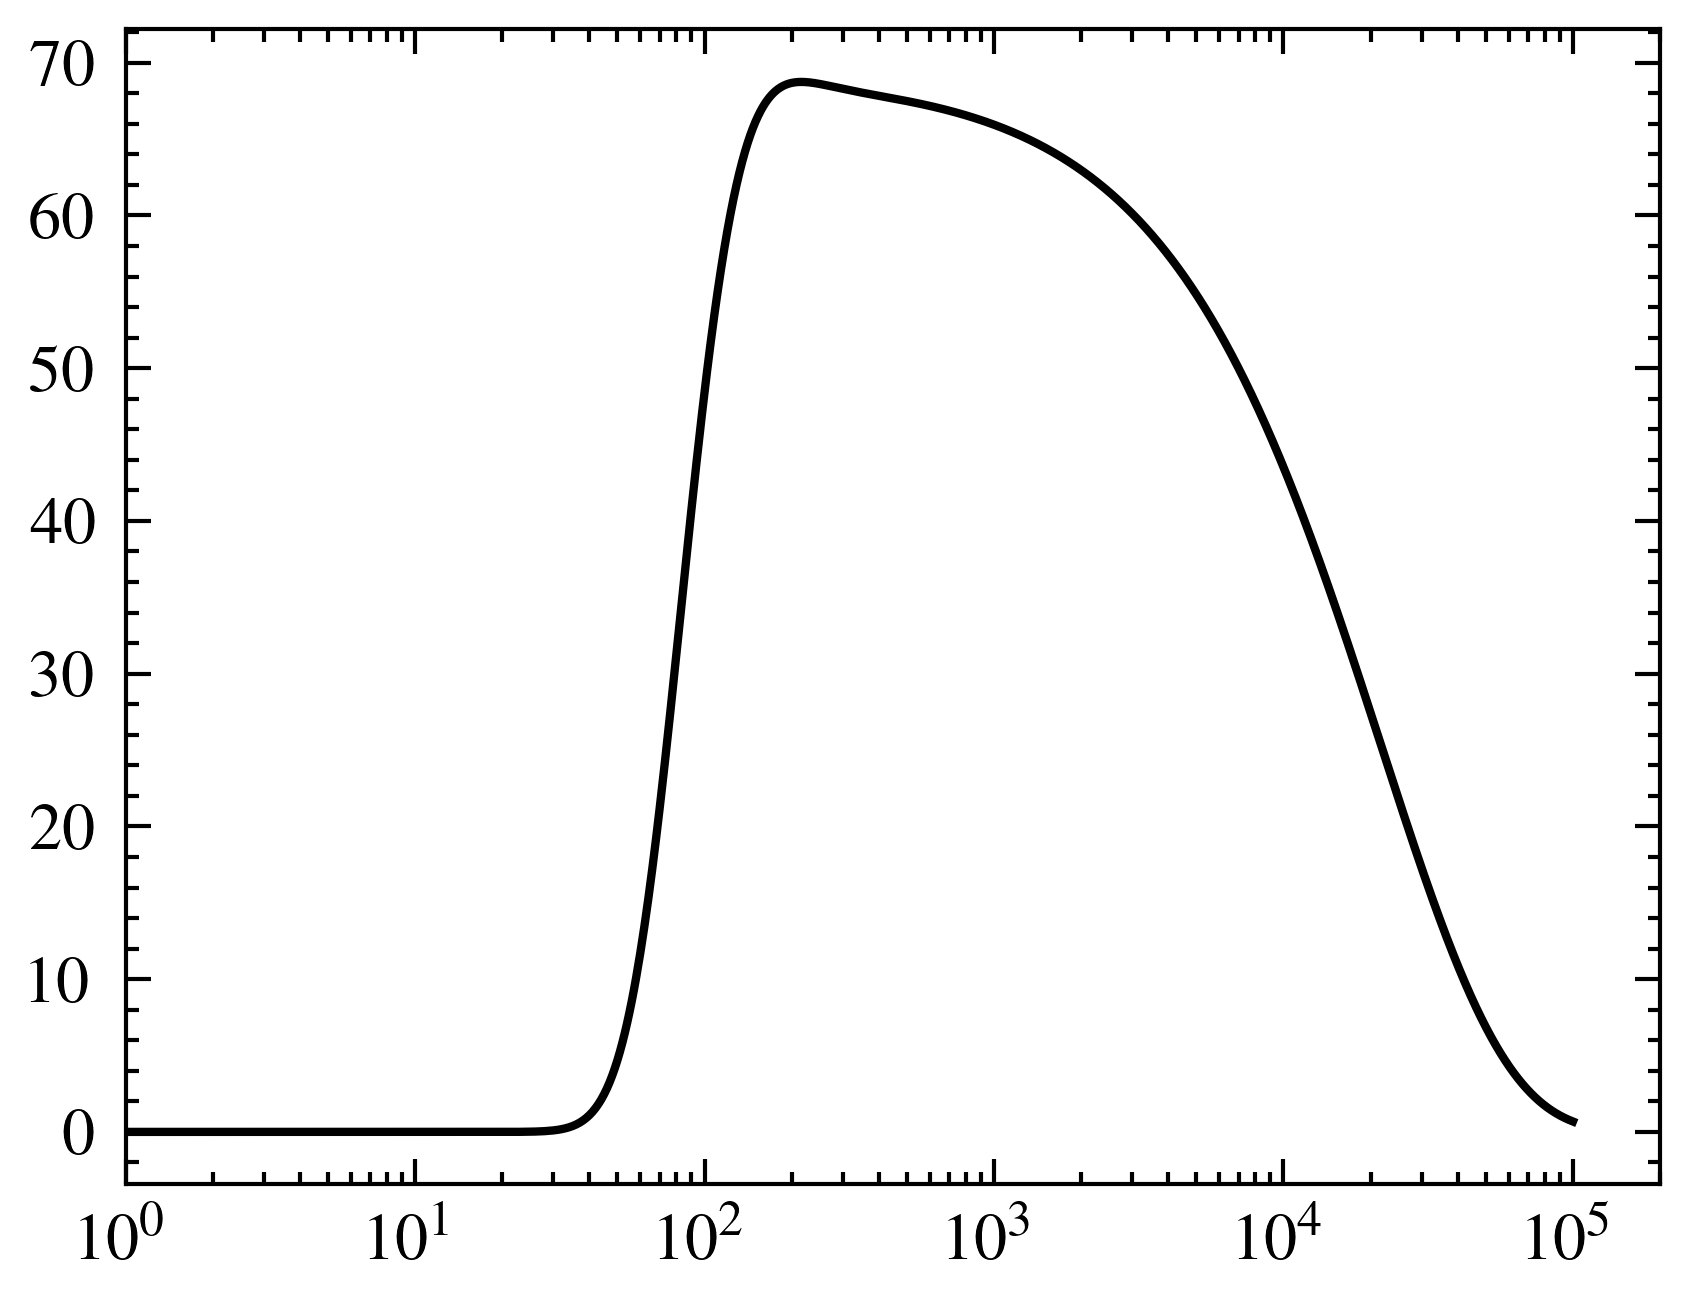

In [40]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(1e-5*sim.rates_evolution[22:, :].sum(axis=0)/cluster_physics.unbiased_jump_rate.magnitude)
#plt.axhline(y = steady_state, color = 'green', linestyle = '--')
#plt.yscale('log')
plt.xlim(1,2e5)
plt.xscale('log')
#plt.yscale('log')
#plt.yscale('log')

(100000.0, 10000000000.0)

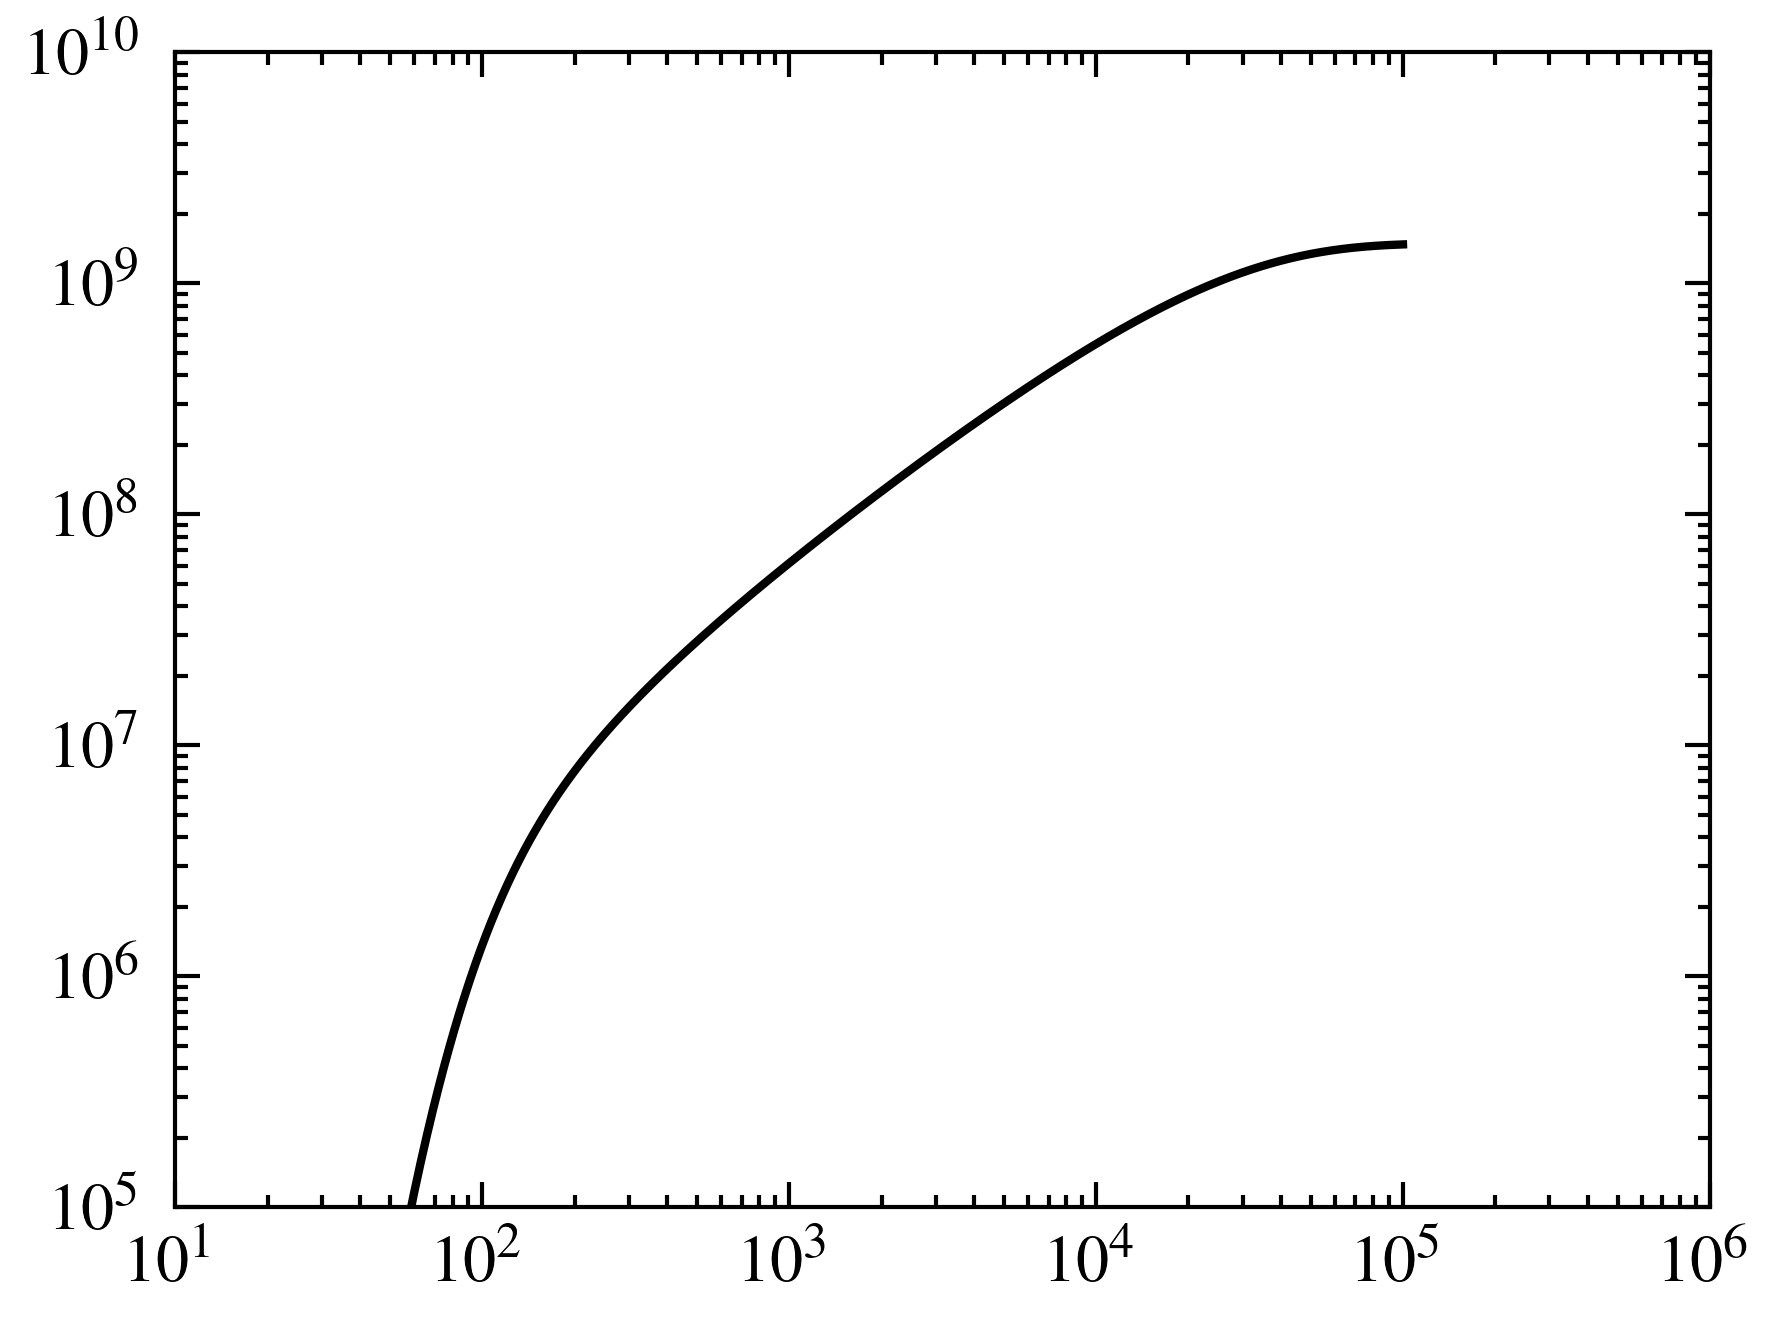

In [41]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(sim.cluster_evolution[22:, :].sum(axis=0))
#plt.axhline(y = steady_state, color = 'green', linestyle = '--')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10,1e6)
plt.ylim(1e5,1e10)
#plt.yscale('log')
#plt.yscale('log')

In [12]:
suma_t = sim.rates_evolution.sum(axis=0)

# 'suma_t' es ahora un array con la suma de los valores para cada paso de tiempo
print(suma_t)

[4.18813201e-07 4.17950160e-07 4.17088943e-07 ... 8.66019096e-09
 8.64450195e-09 8.62884253e-09]


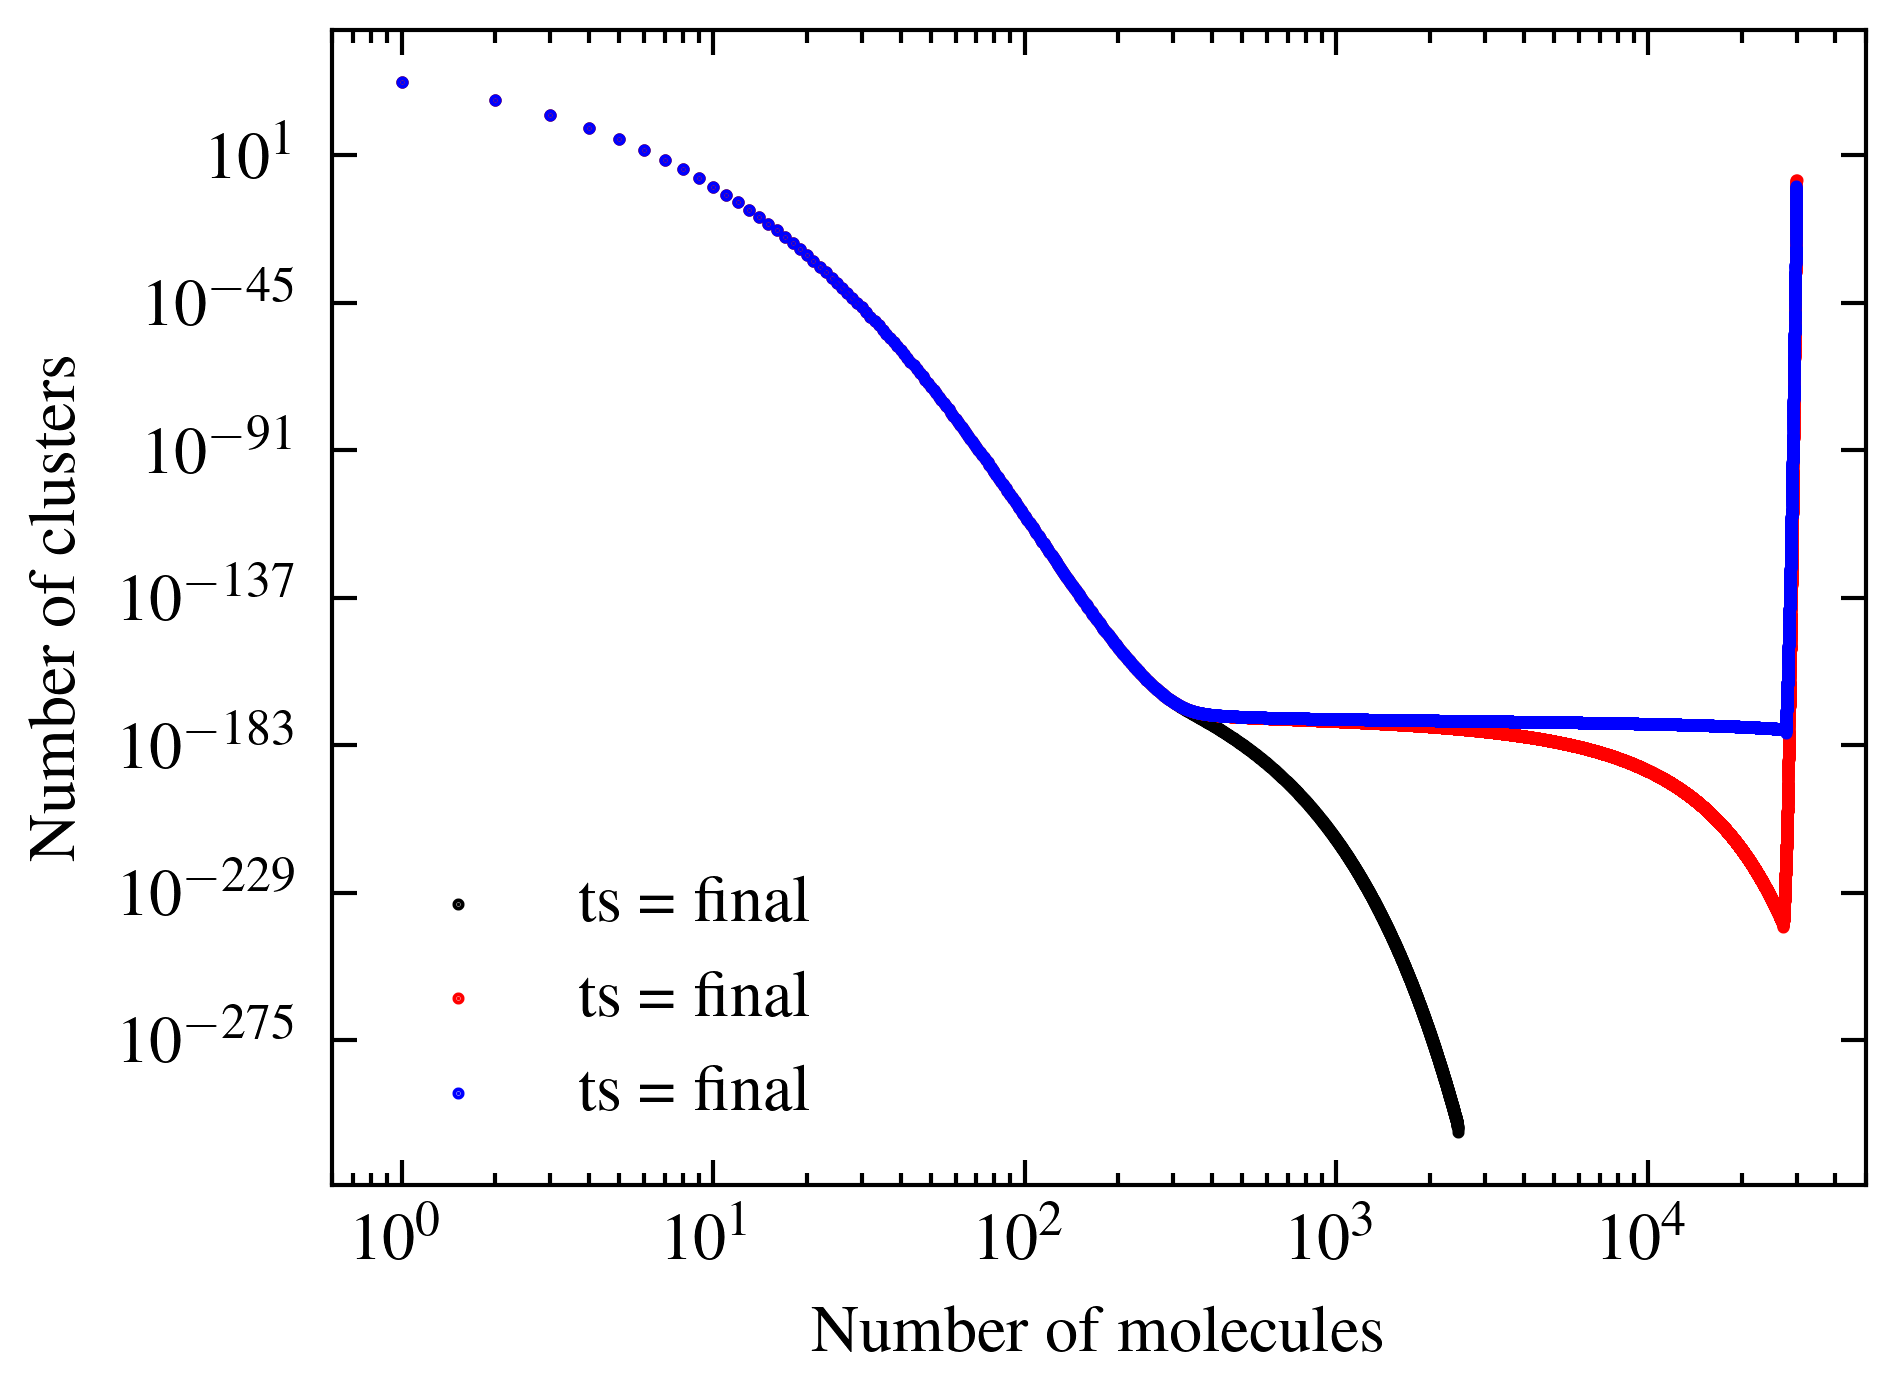

In [73]:
plt.figure()
n = np.linspace(1,500,500)
plt.scatter(sim.number_molecules_array,(sim.cluster_array[:,10]), label = 'ts = final', s=0.2)
plt.scatter(sim.number_molecules_array,(sim.cluster_array[:,30]), label = 'ts = final', s=0.2)
plt.scatter(sim.number_molecules_array,(sim.cluster_array[:,-1]), label = 'ts = final', s=0.2)
#plt.plot(n,(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xscale('log')
plt.yscale('log')

